# Лабораторная работа №2

## Содержание

1. [Постановка задачи и описание входных данных](#1.-Постановка-задачи-и-описание-входных-данных)
2. [Описание решения](#2.-Описание-решения)
    1. [Отделение фона](#2.1.-Отделение-фона)
    2. [Поиск ключевых точек](#2.2.-Поиск-ключевых-точек)
       1. [Нормализация масок](#2.2.1.-Нормализация-масок)
       2. [Поиск ключевых точек](#2.2.2.-Поиск-ключевых-точек)
            1. [Метод выпуклой оболочки](#2.2.2.1.-Метод-выпуклой-оболочки)
            2. [Сканирование](#2.2.2.2.-Сканирование)
            3. [Модифицированное сканирование](#2.2.2.3.-Модифицированное-сканирование)
            4. [Скелетирование](#2.2.2.4.-Скелетирование)
            5. [Поиск экстремумов на границе](#2.2.2.5.-Поиск-экстремумов-на-границе)
            6. [Поиск внутренних углов](#2.2.2.6.-Поиск-внтуренних-углов)
            7. [Итоговый алгоритм](#2.2.2.7.-Итоговый-алгоритм)
    3. [Кластеризация](#2.3.-Кластеризация)
        1. [Описание признаков](#2.3.1.-Описание-признаков)
        2. [Кластеризация](#2.3.2.-Кластеризация)
        3. [Transfer learning](#2.3.3.-Transfer-learning)
3. [Выводы](#Выводы)

# 1. Постановка задачи и описание входных данных

Основной целью данной лабораторной работы является изучить и осовоить методы выделения ключевых точек объектов.

В качестве исходных данных предоставлены фотографии с изображением сканов ладоней разных людей. Возможно, для данной лабораторной работы была предоставлена часть базы [Bosphorus Database](http://bosphorus.ee.boun.edu.tr/).

Поставлены следующие задачи:
* вделить ключевые точки на ладони, а именно кончики пальцев и впадины между пальцами;
* провести кластеризацию изображений (предполагается, что кластеры будут содержать изображения ладоней, пренадлежащих только одному человеку).

### Входные данные

Изображения представляют собой сканы ладоней. Стоит сразу отметить, что изображения ладоней достаточно хорошо должны отделяться от фона, так как фон гораздо темнее цвета кожи ладоней.

Из характерных особенностей изображений можно выделить следующие:
* ладони имеют разный размер;
* ладони по разному раположены на области сканирования (угол и смещение относительно центральной области сканирования);
* ладони принадлежат представителям различных национальностей (различный цвет кожи);
* положения пальцев различны (иногда достаточно сомкнуты, иногда сильно разведены);
* на некоторых изображениях присутвуют элементы одежды.

# 2. Описание решения

Задание можно разделить на следующие этапы:
* отделение фона от изображения ладоней;
* выделение ключевых точек;
* кластеризация изображений.

**Замечание:**
Далее всюду изображение полученное на сканере будем называть *рукой*, внутренню часть кисти без учета пальцев – *ладонью*.

In [1]:
import os
import re
import sys

import numpy as np
import pandas as pd

from collections import Counter
from operator import attrgetter, itemgetter

import cv2
import skimage
import joblib

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def plot_image(img, zoom=1.5):
    assert(2 <= len(img.shape) <= 3)
    
    is_gray = len(img.shape) == 2
    if not is_gray:
        img = img[:,:,::-1]
    n_len = 6.5
    
    n, m = img.shape[:2]
    frac = n / float(m)
    n, m = zoom * frac * n_len, zoom * n_len
    
    fig = plt.figure(figsize=(n, m))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray' if is_gray else None)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis("off")
    plt.show()

In [3]:
def plot_hists(img, x_lim=(0, 255)):
    assert(2 <= len(img.shape) <= 3)
    
    if len(img.shape) == 3:
        f, ax = plt.subplots(3, 1, sharex=True, figsize=(6, 6))
        
        for i, ch in enumerate(['Blue', 'Green', 'Red']):
            values = img[:,:,i].reshape(-1)
            if x_lim != (0, 255):
                mask = np.logical_and(x_lim[0] <= values, values <= x_lim[1])
                values = values[mask]
            
            ax[i].set_xlim(x_lim)
            ax[i].hist(values, bins=x_lim[1]-x_lim[0]+1, color=ch.lower())
            ax[i].set_title(ch)
    elif len(img.shape) == 2:
        f, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 2))
        
        values = img.reshape(-1)
        if x_lim != (0, 255):
            mask = np.logical_and(x_lim[0] <= values, values <= x_lim[1])
            values = values[mask]
        
        ax.set_xlim(x_lim)
        ax.hist(values, bins=x_lim[1]-x_lim[0]+1)
        ax.set_title('Gray')

    plt.show()

In [4]:
def check_image_consistency(img):
    return img.min() == 0 and img.max() == 255 and img.dtype == np.uint8

In [5]:
def scale_image_pixels(img):
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min()) * 255
    return img.astype(np.uint8)

In [6]:
def create_brush(d):
    brush = np.zeros((d, d), dtype=np.uint8)
    cv2.circle(brush, (d // 2, d // 2), d // 2, 1, -1)
    return brush

In [7]:
brush_3 = np.ones((3, 3), dtype=np.uint8)
brush_3[0,0] = brush_3[0,2] = brush_3[2,0] = brush_3[2,2] = 0
brush_3

array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=uint8)

In [8]:
brush_5 = np.ones((5, 5), dtype=np.uint8)
brush_5[0,0] = brush_5[0,4] = brush_5[4,0] = brush_5[4,4] = 0
brush_5

array([[0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0]], dtype=uint8)

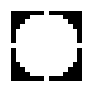

In [9]:
brush_15 = create_brush(15)
plot_image(brush_15, zoom=0.2)

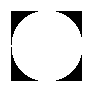

In [10]:
brush_70 = create_brush(70)
plot_image(brush_70, zoom=0.2)

## 2.1. Отделение фона

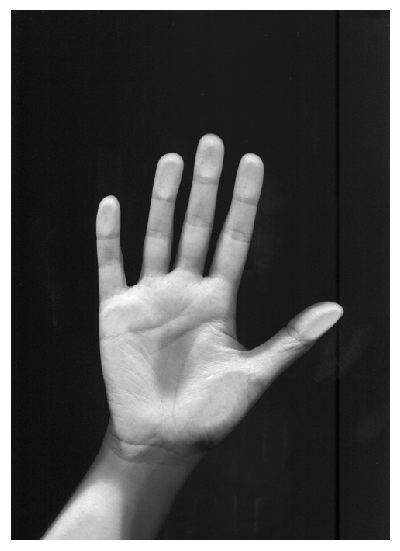

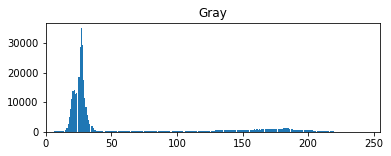

In [11]:
filename = "training/001.tif"

img_gray = cv2.imread(filename, 0)
img_color = cv2.imread(filename, 1)

img_gray_bak = img_gray.copy()
img_color_bak = img_color.copy()

plot_image(img_gray)
plot_hists(img_gray)

По гистограмме видно, что распределение яркостей пикселей на изображении имеет бимодальное распределение. Значит достаточно легко выделить порог бинаризации. Мы не будем использовать никаких методов динамического выбора порога, а сделаем его статитечским. Значение порога подберем руками. 

In [12]:
from scipy.ndimage.morphology import binary_fill_holes

def remove_holes(img):
    assert check_image_consistency(img)

    img = (img > 0).astype(np.uint8)
    img = binary_fill_holes(img)
    img = scale_image_pixels(img)

    assert check_image_consistency(img)
    return img

Дополнительно удалим дырки, если вдруг таковые будут.

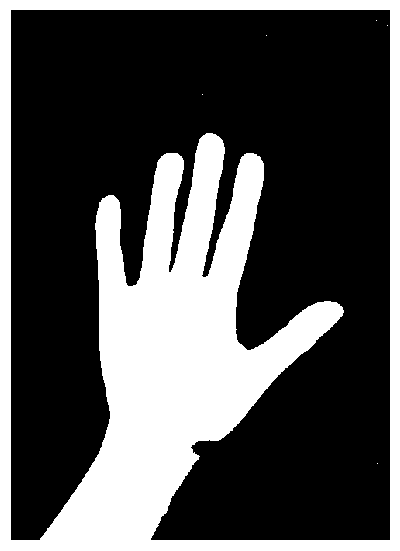

In [13]:
_, img_mask = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)
img_mask = scale_image_pixels(img_mask)
img_mask = remove_holes(img_mask)
plot_image(img_mask)

Рука хорошо выделидась почти полностью. Также легко видеть, что дополнительно выделились некоторые пиксели, не соответвующие руке. Пока не будем обращать на это внимание, удалим их позже.

Для дальнейшей работы, такое изображение не подходит. Хотелось выделить только ладонь и пальцы, а запяcтье – убрать. Для этого рассмотрим скелет руки, а так же применим [distance transform](https://en.wikipedia.org/wiki/Distance_transform).

**Примечание:** далее изображение, полученное после применения *ditsance transform*, будем называть дистанционной картой.

In [14]:
from skimage.morphology import skeletonize

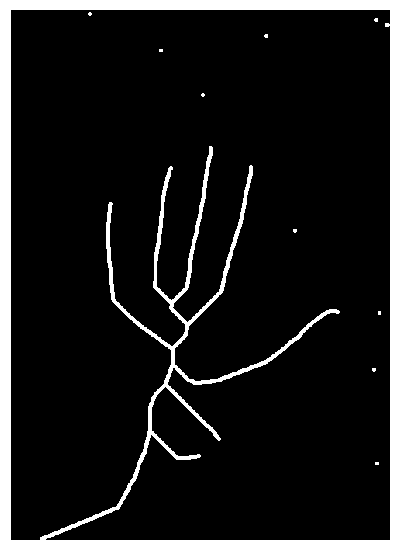

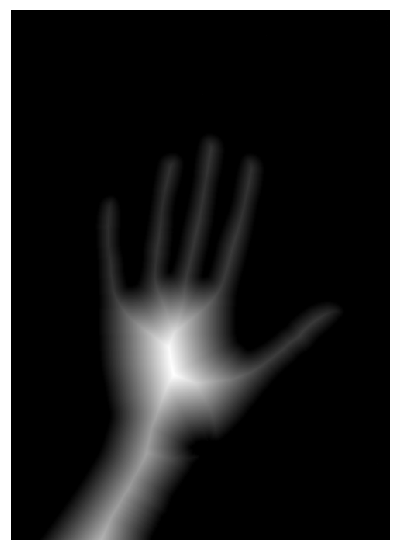

In [15]:
skeleton = skeletonize(img_mask > 0)
skeleton = scale_image_pixels(skeleton)
skeleton = cv2.dilate(skeleton, brush_5)
skeleton = skeleton > 0
plot_image(skeleton)

distance = cv2.distanceTransform(img_mask, cv2.DIST_L2, 5)
plot_image(distance)

Ладонь в первом приближении имеет форму круга, во втором – овала. Поэтому прелагается использовать следующий подход: найдем несколько кругов, которые будут иметь достаточно большой радиус. По ним можно будет "отрезать" запястье и удалить его с изображения. Запястье удаляется с изображения за счет следующего предположения: запястье пересекает границу изоражения.

Очевидно, что одним из таких кругов является круг с центром в точке, где дистанционная карта имеет наибольшее значение (радиус – значение дистанционной карты в этой точке).

Другими подходящими кругами являются точки скелета изображения, а также его окрестностей. Не все точки скелета, подходят. Напомним, что нам нужны только точки с достаточно большим радиусом. Для выбора таких точек опять же обратимся к дистанционной карте – будем выбирать те точки, значения дистанционной карты в которых чуть меньше максимального значения дистанционной карты.

In [16]:
r = distance[np.where(skeleton)]

mask = np.logical_and(skeleton, distance >= .9 * r.max())
centers  = np.where(mask)
radiuses = distance[centers]

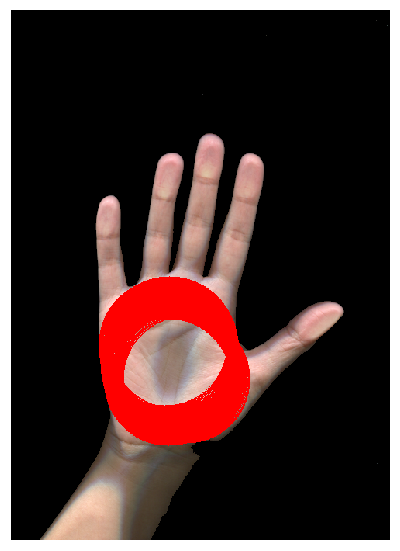

In [17]:
img_color = cv2.bitwise_and(img_color_bak, img_color_bak, mask=img_mask)
for row, col, radius in zip(centers[0], centers[1], radiuses):
    img_color = cv2.circle(img_color, (col, row), radius, (0, 0, 255), 1)
plot_image(img_color)

Однако, данный подход работает не всегда хорошо. Рассмотрим два характерных примера.

In [18]:
def func(img_gray):
    global img_mask, skeleton, distance, r, mask, centers, radiuses 
    
    _, img_mask = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)
    img_mask = scale_image_pixels(img_mask)
    img_mask = remove_holes(img_mask)
    
    skeleton = skeletonize(img_mask > 0)
    skeleton = scale_image_pixels(skeleton)
    skeleton = cv2.dilate(skeleton, brush_5)
    skeleton = skeleton > 0

    distance = cv2.distanceTransform(img_mask, cv2.DIST_L2, 5)
    
    r = distance[np.where(skeleton)]

    mask = np.logical_and(skeleton, distance >= .9 * r.max())
    centers  = np.where(mask)
    radiuses = distance[centers]

**Пример 1:** на изображении отсутвует запястие, поэтому ладонь пересекает границы изображения.

In [19]:
filename = "training/046.tif"

img_gray = cv2.imread(filename, 0)
img_color = cv2.imread(filename, 1)

img_gray_bak = img_gray.copy()
img_color_bak = img_color.copy()

In [20]:
func(img_gray)

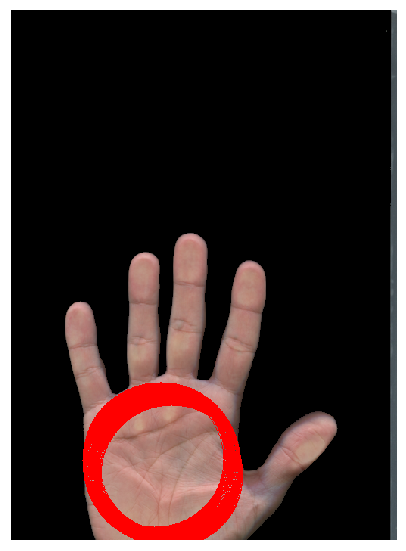

In [21]:
img_color = cv2.bitwise_and(img_color_bak, img_color_bak, mask=img_mask)
for row, col, radius in zip(centers[0], centers[1], radiuses):
    img_color = cv2.circle(img_color, (col, row), radius, (0, 0, 255), 1)
plot_image(img_color)

Очевидно, что с таким подходом большой палец будет удален.

**Пример 2:** особенности выбора порога бинаризации

In [22]:
filename = "training/091.tif"

img_gray = cv2.imread(filename, 0)
img_color = cv2.imread(filename, 1)

img_gray_bak = img_gray.copy()
img_color_bak = img_color.copy()

In [23]:
func(img_gray)

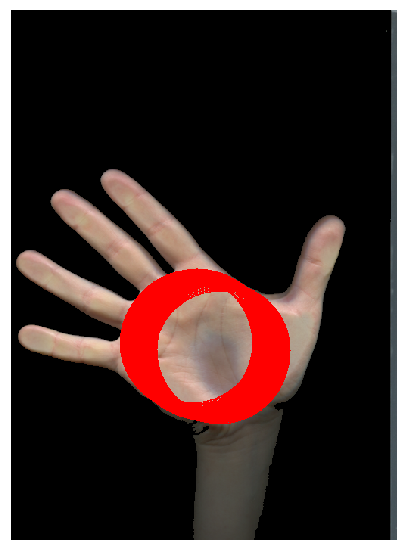

In [24]:
img_color = cv2.bitwise_and(img_color_bak, img_color_bak, mask=img_mask)
for row, col, radius in zip(centers[0], centers[1], radiuses):
    img_color = cv2.circle(img_color, (col, row), radius, (0, 0, 255), 1)
plot_image(img_color)

Заметим, что в этом случае большой палец не отделился от запястья, поэтому при удалении запястья, большой палец будет также удален.

В обоих случаях данную проблему легко решить просто увеличив радиус окружностей.

In [25]:
radiuses = radiuses + 10

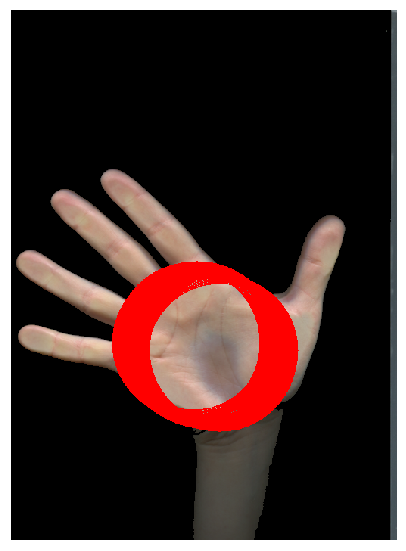

In [26]:
img_color = cv2.bitwise_and(img_color_bak, img_color_bak, mask=img_mask)
for row, col, radius in zip(centers[0], centers[1], radiuses):
    img_color = cv2.circle(img_color, (col, row), radius, (0, 0, 255), 1)
plot_image(img_color)

Теперь можно перейти к удалению запястья.

In [27]:
def remove_border_objects(img):
    assert check_image_consistency(img)

    img = img.copy()
    img[0, :] = 255
    img[:, 0] = 255
    img[img.shape[0] - 1, :] = 255
    img[:, img.shape[1] - 1] = 255

    h, w = img.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)

    cv2.floodFill(img, mask, (0, 0), 0)

    assert check_image_consistency(img)
    return img

In [28]:
from skimage.measure import label, regionprops

def remove_small_objects(img, area=300):
    assert check_image_consistency(img)
    
    img = img.copy()
    img_labels = label(img)
    
    img_labels_remove = set([prop.label for prop in regionprops(img_labels)
                             if prop.area < area])

    mask = map(lambda x: x in img_labels_remove, img_labels.reshape(-1))
    mask = np.array(mask).reshape(img_labels.shape)

    img[mask] = 0
    
    assert check_image_consistency(img)
    return img

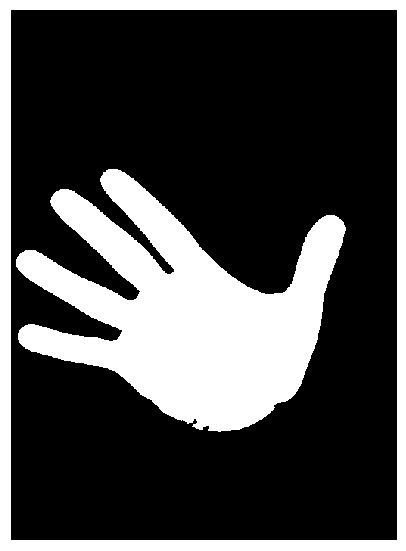

In [29]:
img_mask_copy = img_mask.copy()

center = np.unravel_index(np.argmax(distance, axis=None), distance.shape)
radius_ = int(np.ceil(distance[center[0], center[1]]) + 10)

img_mask = cv2.circle(img_mask, (center[1], center[0]), radius_, 0, -1)
for row, col, radius in zip(centers[0], centers[1], radiuses):
    img_mask = cv2.circle(img_mask, (col, row), radius, 0, -1)
img_mask = remove_border_objects(img_mask)

img_mask = remove_small_objects(img_mask)

img_mask = cv2.circle(img_mask, (center[1], center[0]), radius_, 255, -1)
for row, col, radius in zip(centers[0], centers[1], radiuses):
    img_mask = cv2.circle(img_mask, (col, row), radius, 255, -1)
img_mask = cv2.bitwise_and(img_mask, img_mask_copy)

plot_image(img_mask)

Однако запястье не всегда контактирует с границей изображения. Рассмотрим один из плохих примеров.

In [30]:
func_prev = func

def func(img_gray):
    global radiuses, img_mask_copy, center, radius_, img_mask
    
    func_prev(img_gray)
    radiuses = radiuses + 10
    
    img_mask_copy = img_mask.copy()

    center = np.unravel_index(np.argmax(distance, axis=None), distance.shape)
    radius_ = int(np.ceil(distance[center[0], center[1]]) + 10)

    img_mask = cv2.circle(img_mask, (center[1], center[0]), radius_, 0, -1)
    for row, col, radius in zip(centers[0], centers[1], radiuses):
        img_mask = cv2.circle(img_mask, (col, row), radius, 0, -1)
    img_mask = remove_border_objects(img_mask)
    
    img_mask = remove_small_objects(img_mask)

    img_mask = cv2.circle(img_mask, (center[1], center[0]), radius_, 255, -1)
    for row, col, radius in zip(centers[0], centers[1], radiuses):
        img_mask = cv2.circle(img_mask, (col, row), radius, 255, -1)
    img_mask = cv2.bitwise_and(img_mask, img_mask_copy)


In [31]:
filename = "training/144.tif"

img_gray = cv2.imread(filename, 0)
img_color = cv2.imread(filename, 1)

img_gray_bak = img_gray.copy()
img_color_bak = img_color.copy()

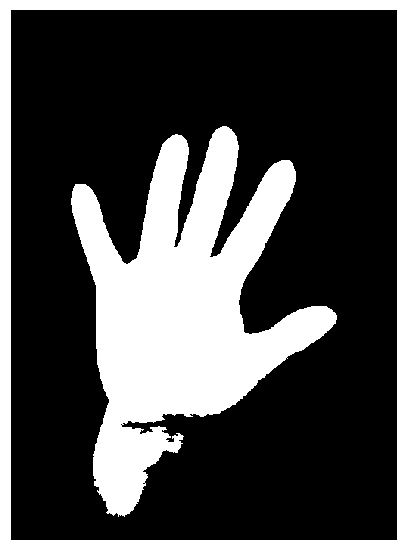

In [32]:
func(img_gray)
plot_image(img_mask)

С такими проблемами можно справиться, повысив порог бинаризации для части изображения под маской.

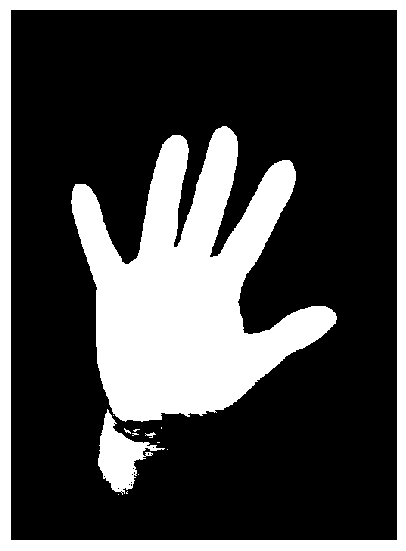

In [33]:
img_mask = cv2.bitwise_and(img_gray, img_gray, mask=img_mask)

_, img_mask = cv2.threshold(img_mask, 55, 255, cv2.THRESH_BINARY)
plot_image(img_mask)

Теперь можно удалить все лишние объекты. В данном случае удобно пользоваться предположением, что ладонь и пальцы – наибольший объект на изображении.

In [34]:
def find_largest_object(img, copy=True):
    assert check_image_consistency(img)
    
    if copy:
        img = img.copy()
    
    img_labels = label(img)
    img_props = sorted(regionprops(img_labels), key=attrgetter('area'), reverse=True)[0]
    img[np.where(img_labels != img_props.label)] = 0
    
    assert check_image_consistency(img)
    return img

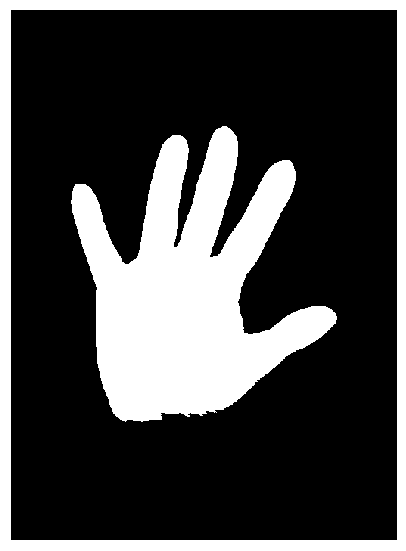

In [35]:
img_mask = find_largest_object(img_mask)
img_mask = remove_holes(img_mask)

plot_image(img_mask)

In [36]:
sys.path.append('src')

In [37]:
from processing.masks import create_hand_mask

## 2.2. Поиск ключевых точек

Задачу поиск ключевых точек можно разделить на два этапа:
1. нормализация масок для ладоней и пальцев;
2. непосредственно сам поиск.

In [38]:
filename = "training/050.tif"

img_gray = cv2.imread(filename, 0)
img_color = cv2.imread(filename, 1)

img_gray_bak = img_gray.copy()
img_color_bak = img_color.copy()

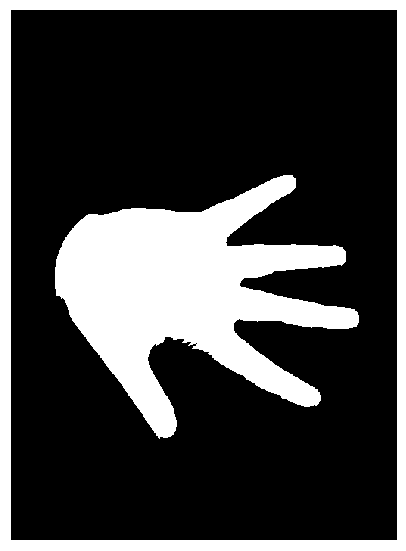

In [39]:
img_hand = create_hand_mask(img_gray)
plot_image(img_hand)

## 2.2.1. Нормализация масок

Сначала поясним для чего нужна нормализация в данной задаче. Она нужна для того, чтобы упростить поиск ключевых точек, появляется возможность придумать универсальный алгоритм.

Нормализация в нашем случае заключается в следующем: центрируем изображение и разворачиваем ладонь так, чтобы пальцы смотрели вверх (желательно чтобы средний палец был вертикально выравнен).

In [40]:
from skimage import transform as tf

In [41]:
tforms = []

In [42]:
def center_object_on_image(img, img_props):    
    assert check_image_consistency(img)
    
    min_row, min_col, _, _ = img_props.bbox
    tform1 = tf.SimilarityTransform(translation=(min_col, min_row))
    
    box_row_num, box_col_num = img_props.filled_image.shape
    img_row_num, img_col_num = img.shape[0], img.shape[1]

    row = (img_row_num - box_row_num) // 2
    col = (img_col_num - box_col_num) // 2

    tform2 = tf.SimilarityTransform(translation=(-col, -row))
    tform = tform2 + tform1
    
    img = tf.warp(img, tform)
    img = scale_image_pixels(img)
    img = (img > 128).astype(np.uint8) * 255
    
    assert check_image_consistency(img)
    return img, tform

In [43]:
def rotate_image(img, rads):
    assert check_image_consistency(img)
    
    rows, cols = img.shape[0], img.shape[1]
    center = np.array((cols, rows)) / 2. - 0.5
    
    tform1 = tf.SimilarityTransform(translation=center)
    tform2 = tf.SimilarityTransform(rotation=rads)
    tform3 = tf.SimilarityTransform(translation=-center)
    tform = tform3 + tform2 + tform1

    img = tf.warp(img, tform)
    img = scale_image_pixels(img)
    img = (img > 200).astype(np.uint8) * 255
    
    assert check_image_consistency(img)    
    return img, tform

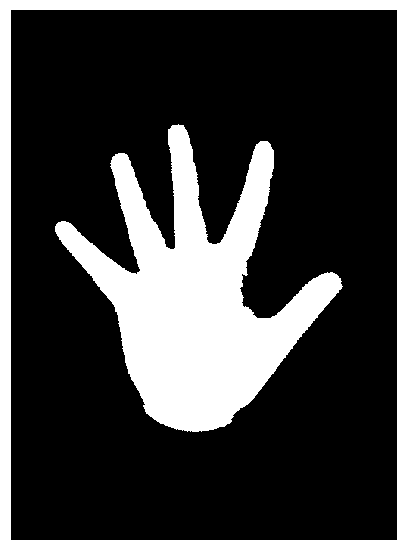

In [44]:
img_mask = img_hand.copy()

img_labels = label(img_mask)
img_props = regionprops(img_labels)[0]

# Центрируем объект
img_mask, tform = center_object_on_image(img_mask, img_props)
tforms.append(tform)

# Доворот, чтобы средний палец смотрел вверх
angle = np.pi / 2 - img_props.orientation
angle += np.pi / 15

img_mask, tform = rotate_image(img_mask, angle)
img_mask = find_largest_object(img_mask)
tforms.append(tform)

# Разворачиваем изображение, если пальцы опущены вниз
img_labels = label(img_mask)
img_props = regionprops(img_labels)[0]
centroid = img_props.centroid
if centroid[0] < img_mask.shape[0] // 2:
    img_mask, tform = rotate_image(img_mask, np.pi)
    tforms.append(tform)
    
# Немного сглаживаем границу
img_mask = scale_image_pixels(img_mask)
img_mask = cv2.erode(img_mask, brush_3, iterations=2)
img_mask = cv2.dilate(img_mask, brush_3, iterations=2)
img_mask = remove_holes(img_mask)

plot_image(img_mask)

In [45]:
from processing.masks import position_hand_mask

## 2.2.2. Поиск ключевых точек

После того, как маска для ладони нормализована, можно приступать к поиску ключевых вершин.

Далее сформулируем несколько опробованных мною подходов, кратко обсудим их плюсы и минусы, а затем в конце опишем финальных подход.

In [46]:
from scipy.spatial import distance_matrix

def choose_unique_points(points, thrsh=15.0):
    points = np.array(points)

    points_dist = distance_matrix(points, points) < thrsh
    points_order = np.argsort(points_dist.sum(axis=0))[::-1]
    points = points[points_order]
    points_dist = points_dist[points_order][:, points_order]

    points_processed, points_chosen = set(), set()

    for i in range(len(points)):
        if i in points_processed:
            continue
        points_processed.add(i)
        points_chosen.add(i)
        points_processed |= set(np.where(points_dist[i])[0].tolist())

    points = points[list(points_chosen)]
    return points

In [47]:
def argsort_vertices(vertices, center):
    vertices = np.array(vertices, dtype=np.float32, ndmin=2)
    center = np.array(center, dtype=np.float32, ndmin=2)

    assert 2 == vertices.shape[1] == center.shape[1]

    def cart2pol(vectors):
        rho = np.linalg.norm(vectors, axis=1)
        phi = np.arctan2(vectors[:, 1], vectors[:, 0])
        return rho, phi

    vertices -= center
    vertices *= np.array([[1, -1]])
    _, angles = cart2pol(vertices)

    index = np.argsort(angles)[::-1]
    return index

### 2.2.2.1. Метод выпуклой оболочки

Данный метод подходит только для поиска кончиков пальцев. Метод заключается в следующем: строится выпуклая оболчка, вершины выпуклой оболочки берутся за кончики пальцев.

Обсудим его самым первым, как наиболее плохой.

In [48]:
from skimage.color import gray2rgb

In [49]:
def func(img_hand):
    _, contours, _ = cv2.findContours(img_hand, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = contours[0]
    epsilon = 0.03 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True, cv2.CHAIN_APPROX_SIMPLE)

    img_hand_hull = cv2.convexHull(approx)
    p_tips = img_hand_hull[:,0,:].tolist()
    
    p_tips = choose_unique_points(p_tips, 40.0)
    
    img_props = regionprops(label(img_hand))[0]
    row_center, col_center = img_props.centroid
    center = np.array((col_center, row_center), ndmin=2)

    """
    index = argsort_vertices(p_tips, center)
    p_tips = p_tips[index]
    """

    img_mask = gray2rgb(img_hand)
    for row, col in p_tips:
        cv2.circle(img_mask, (row, col), 5, (0, 0, 255), -1)
    plot_image(img_mask)

Image: 093


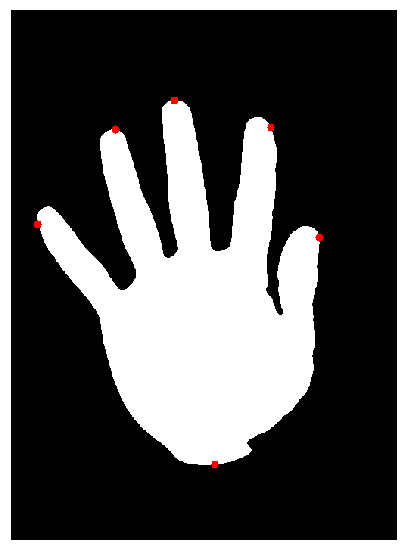

Image: 002


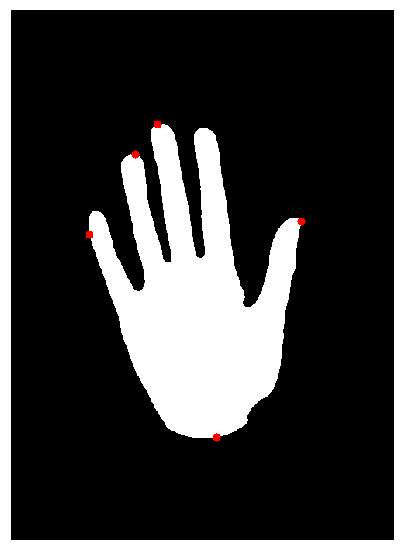

In [50]:
for i in ['093', '002']:
    filename = "training/{}.tif".format(i)
    print "Image: {}".format(i)

    img_gray = cv2.imread(filename, 0)

    img_hand = create_hand_mask(img_gray)
    img_hand, tform = position_hand_mask(img_hand)

    func(img_hand)

Впрочем, ничего хорошего нельзя сказать об этом методе. Он чрезвычайно ситуативнный и недетерминированный. 

### 2.2.2.2. Сканирование

Метод сканирования заключается в следующем: построчно спускаемся сверху вниз по изображению и ищем точки, соответствующие кончикам пальцев и низинами между ними.

Ниже представлен метод, который для данной строки возвращает список найденных кончиков и низин.

In [51]:
def find_tips_and_valleys(img, curr_i):
    prev_i = curr_i - 1

    row_curr = img[curr_i]
    row_prev = img[prev_i] if prev_i >= 0 else np.zeros(row_curr.shape)

    m_prev = label(row_prev)
    m_curr = (row_curr > 0) * 255
    m_curr[m_prev > 0] = m_prev[m_prev > 0]

    """
    Заполняем маску для текущей строки
    
    Пусть предыдущая строка имеет вид:
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]
    Тогда разметка (кластеры) для этой строки имеет вид:
        [0, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 3, 0, 0]
    
    Текущая строка получается из предыдущей заменой
    черных пикселей на белые и наоборот. Требуется добавить
    все новые белые точки к кластерам из предыдущей строки.
    
    Пусть текущая строка иммет вид:
        [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]
    Тогда маска для этой строки, которую мы получаем из
    разметки (кластеров) для предыдущей строки будет иметь вид:
        [0, 0, 1, 1, 1, 0, 0, 2, 2, 0, 0, 3, 0, 255]
    
    Значение 255 символизирует о том, что точка не была
    добавлена ни к одному из кластеров предыдущей строки.
    """
    
    """
    Добавляем метки для всех новых точек проходом слева направо
    """
    for i in range(1, len(m_curr)):
        if m_curr[i] != 255:
            continue
        if m_curr[i - 1] == 0 or m_curr[i - 1] == 255:
            continue
        m_curr[i] = m_curr[i - 1]

    """
    Добавляем метки для всех новых точек проходом справа налево
    """
    for i in range(0, len(m_curr) - 1)[::-1]:
        if m_curr[i] != 255:
            continue
        if m_curr[i + 1] == 0 or m_curr[i + 1] == 255:
            continue
        m_curr[i] = m_curr[i + 1]
        
    """
    Все белые точки это новый кончик (tip). Вычислим координаты
    кончиков -- центроиды новых кластеров белых точек.
    """
    p_tips = []
    mask_points_tips = m_curr == 255
    if mask_points_tips.any():
        m_tips, m_tips_max = label(mask_points_tips, return_num=True)
        for i in range(1, m_tips_max + 1):
            p_tip = int(np.mean(np.where(m_tips == i)[0]))
            p_tips.append(p_tip)
        m_curr[mask_points_tips] = 0

    """
    Перейдем к поиску низин (valleys). Будем считать, что низина
    получается тогда, когда происходит слияние двух кластеров
    белых точек предыдущей строки.
    """
    p_valleys = []
    bordering_labels = [(lc, ln) for lc, ln in zip(m_curr[:-1], m_curr[1:])
                        if lc != ln and lc > 0 and ln > 0]

    """
    Иногда не два кластера сливаются в один, а более.
    Рассмотрим пример.
    
    Кластеры предыдущей строки:
        [0, 1, 1, 1, 0, 0, 2, 2, 0, 3, 3]
    Разметка для новой строки (см. алгоритм построения маски для
    текущей строки в два прохода):
        [0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3]
    Здесь кластеры (1, 2, 3) сливаются в один.
    
    Требуется различать два случая:
        * кластеры создают одну низину (1, 2, 3);
        * кластеры создают две низины  (1, 2) и (2, 3).
    """
    if len(bordering_labels) > 1:
        bordering_labels_ = []
        
        l_prev, r_prev = bordering_labels[0]
        for l_curr, r_curr in bordering_labels[1:]:
            if r_prev == l_curr:
                l_border = np.max(np.where(m_prev == l_prev)[0])
                r_border = np.min(np.where(m_prev == r_curr)[0])
                
                """
                Провека, что кластеры сливаются в одну низину.
                Идея заключается в следующем: расстоние между правой
                границей левого кластера и левой -- правого мало.
                """
                if r_border - l_border < 40:
                    r_prev = r_curr
                    continue
            
            bordering_labels_.append((l_prev, r_prev))
            l_prev, r_prev = l_curr, r_curr
            
        bordering_labels_.append((l_prev, r_prev))
        bordering_labels = bordering_labels_

    """
    Координата низины -- середина между границами левого
    и правого кластеров.
    """
    for l_curr, l_next in bordering_labels:
        l_border = np.where(m_prev == l_curr)[0][-1]
        r_border = np.where(m_prev == l_next)[0][0]
        point = (l_border + r_border) // 2
        p_valleys.append(point)

    return p_tips, p_valleys

In [52]:
def func(img_hand):
    img_color = gray2rgb(img_hand)

    p_tips_cumm, p_valleys_cumm = [], []

    for row in range(img_hand.shape[0]):
        if (img_hand[row,:-1] - img_hand[row,1:] > 0).sum() == 0:
            continue
    
        p_tips, p_valleys = find_tips_and_valleys(img_hand, row)
        p_tips_cumm.extend([(col, row) for col in p_tips])
        p_valleys_cumm.extend([(col, row) for col in p_valleys])

        """
        if len(p_tips) > 0 and len(p_valleys) > 0:
            img_color[row] = (255, 0, 255)
        elif len(p_tips) > 0:
            img_color[row] = (0, 0, 255)
        elif len(p_valleys) > 0:
            img_color[row] = (255, 0, 0)
        """

    p_tips_cumm = choose_unique_points(p_tips_cumm, 40.0)
    p_valleys_cumm = choose_unique_points(p_valleys_cumm, 40.0)

    img_props = regionprops(label(img_hand))[0]
    row_center, col_center = img_props.centroid
    center = np.array((col_center, row_center), ndmin=2)

    index = argsort_vertices(p_tips_cumm, center)
    p_tips_cumm = p_tips_cumm[index]

    index = argsort_vertices(p_valleys_cumm, center)
    p_valleys_cumm = p_valleys_cumm[index]

    for p1, p2 in zip(p_tips_cumm[:-1], p_valleys_cumm):
        cv2.line(img_color, tuple(p1), tuple(p2), (34, 199, 34), 2)
    for p1, p2 in zip(p_tips_cumm[1:], p_valleys_cumm):
        cv2.line(img_color, tuple(p1), tuple(p2), (34, 199, 34), 2)
    
    for col, row in p_tips_cumm:
        cv2.circle(img_color, (col, row), 6, (34, 34, 199), -1)
        cv2.circle(img_color, (col, row), 3, (255, 255, 255), -1)
    
    for col, row in p_valleys_cumm:
        cv2.circle(img_color, (col, row), 6, (199, 34, 34), -1)
        cv2.circle(img_color, (col, row), 3, (255, 255, 255), -1)
    
    plot_image(img_color)

Image: 002


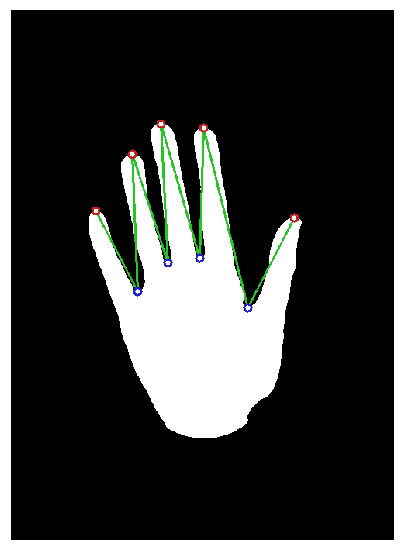

Image: 035


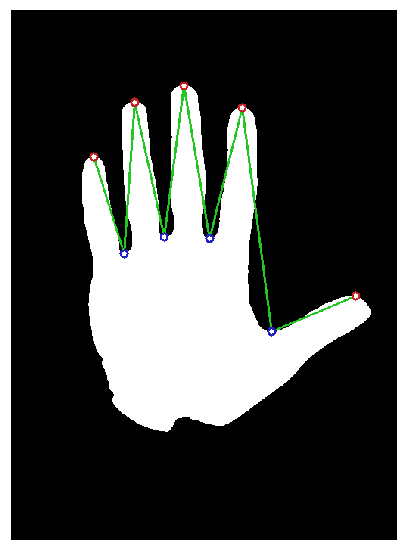

Image: 093


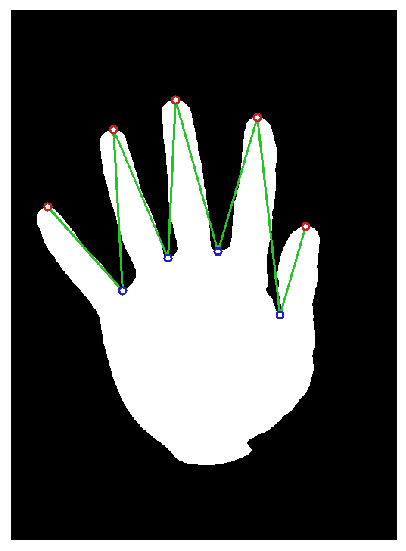

Image: 014


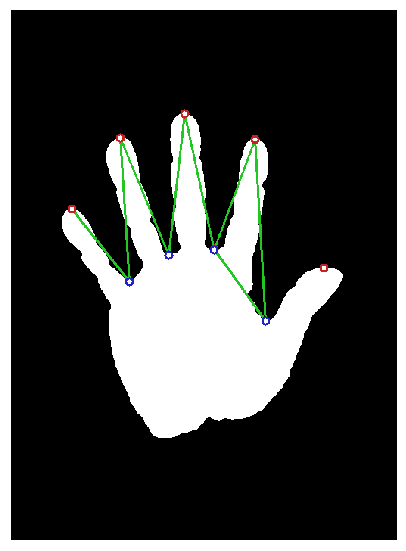

In [53]:
for i in ['002', '035', '093', '014']:
    filename = "training/{}.tif".format(i)
    print "Image: {}".format(i)

    img_gray = cv2.imread(filename, 0)

    img_hand = create_hand_mask(img_gray)
    img_hand, tform = position_hand_mask(img_hand)

    func(img_hand)

Данный подход показывает в целом неплохие результаты – на большей части изображений он довольно неплохо находит ключевые точки. Его определенно можно использовать с определенными доработками.

Отметим его **недостатки**:
1. метод очень чувствителен к неровной границе (из-за этого появляются мнимые впадины и выпуклости);
* метод сильно зависит от нормализации маски:
    * кончик большого пальца начинает смещаться на подушечку;
    * впадина между крайними парами пальцев также смещается от истинного положения;
* 67 строк чистого кода.

### 2.2.2.3. Модифицированное сканирование

Данный метод – модификация метода сканирования. Сначала выделим области соответвующие ладони и пальцам. Пальцы будем нормализовывать способом описанным выше и уже в таком состоянии будем искать для них кончики методом сканирования. Низины также по-прежнему будем искать обычным сканированием.

In [54]:
filename = "training/135.tif"
img_gray = cv2.imread(filename, 0)

img_hand = create_hand_mask(img_gray)
img_hand, tform = position_hand_mask(img_hand)

Выделение пальцев можно выполнить с помощью применения открытия с использованием круга большого радиуса.

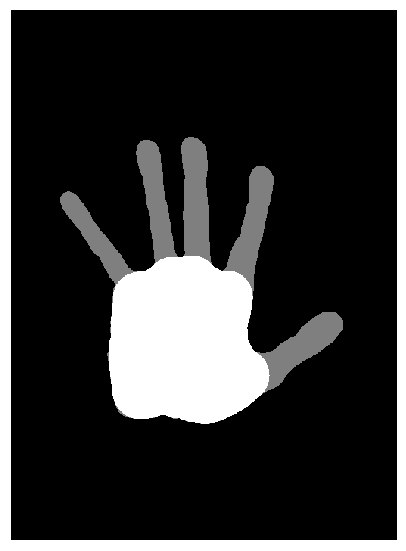

In [55]:
img_mask = img_hand.copy()
img_mask = cv2.morphologyEx(img_mask, cv2.MORPH_OPEN, brush_70)
img_mask = cv2.bitwise_or(img_mask, img_mask, mask=img_hand)
img_mask_raw = (img_hand > 0) * 127
img_mask = np.maximum(img_mask, img_mask_raw)
plot_image(img_mask)

Отметим еще несколько плюсов данной декомпозции:
1. преобразование позволяет хорошо сгладить границы ладони, особенно в области запястия;
* предоставляется возможность точнее найти общий геометрический центр ладони и пальцев.

In [56]:
from processing.masks import create_palm_and_fingers_masks

In [57]:
img_hand, img_palm, img_fingers = create_palm_and_fingers_masks(img_hand)

In [58]:
def func_fingers(img_fingers, img_palm):
    img_labels, n_labels = label(img_fingers, return_num=True)

    p_tips = []
    for props in regionprops(img_labels):    
        img_finger = img_fingers.copy()
        mask = img_labels != props.label
        img_finger[np.where(mask)] = 0
    
        img_finger, tform_1 = center_object_on_image(img_finger, props)
    
        """
        Пальцы уже изначально развернуты так, что должны поворачиваться
        на угол не больший 95°
        """
        angle = np.pi / 2 - props.orientation
        if angle > np.pi / 2:
            angle = np.pi + angle
        img_finger, tform_2 = rotate_image(img_finger, angle)
        tform = tform_2 + tform_1
    
        for row in range(img_finger.shape[0]):
            if img_finger[row].sum() == 0:
                continue
            cols, _ = find_tips_and_valleys(img_finger, row)
            point = (int(cols[0]), row, 1)
            point = np.array(point).astype(np.int32)
            break
    
        point = np.matmul(tform.params, point.T)
        p_tips.append(point[:2])

    p_tips = np.vstack(p_tips)

    img_props = regionprops(label(img_palm))[0]
    row_center, col_center = img_props.centroid
    center = np.array((col_center, row_center), ndmin=2)

    index = argsort_vertices(p_tips, center)
    p_tips = p_tips[index]
    
    return p_tips

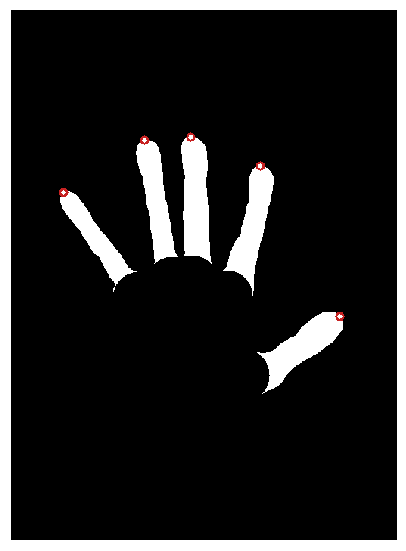

In [59]:
img_color = gray2rgb(img_fingers)
p_tips = func_fingers(img_fingers, img_palm)

for col, row in p_tips.astype(np.int32):
    cv2.circle(img_color, (col, row), 6, (34, 34, 199), -1)
    cv2.circle(img_color, (col, row), 3, (255, 255, 255), -1)
    
plot_image(img_color)

Ладонь, в том виде в котором мы имеем ее сейчас, не позволяет надежно находить низины. Чтобы исправить это, добавим к ладони немного области пальцев. Это можно сделать с помощью дилатации кистью меньшего радиуса.

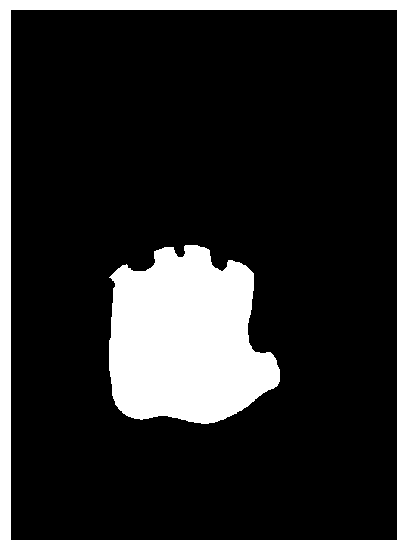

In [60]:
img_mask = img_palm.copy()
img_mask = cv2.dilate(img_mask, brush_15)
img_mask = cv2.dilate(img_mask, brush_15)
img_mask = cv2.bitwise_or(img_mask, img_mask, mask=img_hand)
plot_image(img_mask)

In [61]:
def func_palm(img_palm):
    img_mask = img_palm.copy()
    img_mask = cv2.dilate(img_mask, brush_15)
    img_mask = cv2.dilate(img_mask, brush_15)
    img_mask = cv2.bitwise_or(img_mask, img_mask, mask=img_hand)

    p_valleys = []
    
    for row in range(img_mask.shape[0]):
        _, cols = find_tips_and_valleys(img_mask, row)
        if len(cols) > 0:
            point = [(col, row) for col in cols]
            p_valleys.extend(point)
            
    p_valleys = np.vstack(p_valleys)
    p_valleys = choose_unique_points(p_valleys, 40.0)
    
    img_props = regionprops(label(img_palm))[0]
    row_center, col_center = img_props.centroid
    center = np.array((col_center, row_center), ndmin=2)
    
    index = argsort_vertices(p_valleys, center)
    p_valleys = p_valleys[index]
    
    return p_valleys

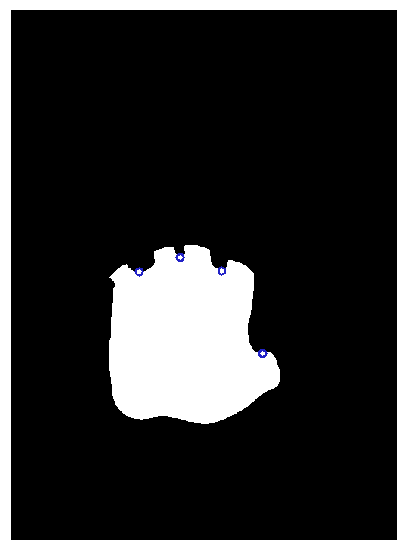

In [62]:
img_color = gray2rgb(img_mask)
p_valleys = func_palm(img_palm)

for col, row in p_valleys.astype(np.int32):
    cv2.circle(img_color, (col, row), 6, (199, 34, 34), -1)
    cv2.circle(img_color, (col, row), 3, (255, 255, 255), -1)
    
plot_image(img_color)

Продемонстрируем работу алгоритма на нескольких изображениях.

In [63]:
def func(img_hand, img_palm, img_fingers):
    p_tips = func_fingers(img_fingers, img_palm).astype(np.int32)
    p_valleys = func_palm(img_palm).astype(np.int32)
    
    img_color = gray2rgb(img_hand)
    
    for p1, p2 in zip(p_tips[:-1], p_valleys):
        cv2.line(img_color, tuple(p1), tuple(p2), (34, 199, 34), 2)
    for p1, p2 in zip(p_tips[1:], p_valleys):
        cv2.line(img_color, tuple(p1), tuple(p2), (34, 199, 34), 2)
    
    for col, row in p_tips:
        cv2.circle(img_color, (col, row), 6, (34, 34, 199), -1)
        cv2.circle(img_color, (col, row), 3, (255, 255, 255), -1)
    
    for col, row in p_valleys:
        cv2.circle(img_color, (col, row), 6, (199, 34, 34), -1)
        cv2.circle(img_color, (col, row), 3, (255, 255, 255), -1)
    
    plot_image(img_color)

Image: 002


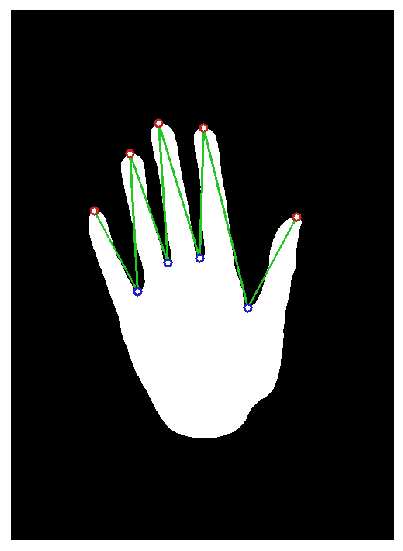

Image: 035


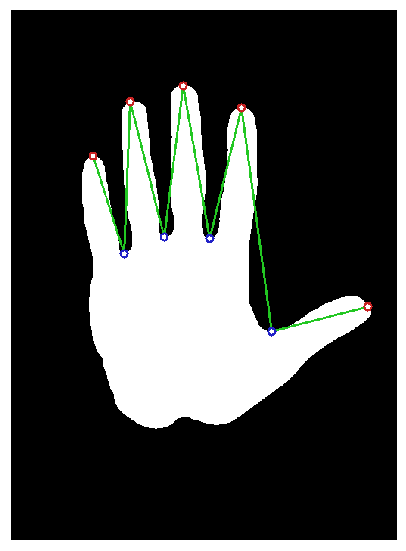

Image: 093


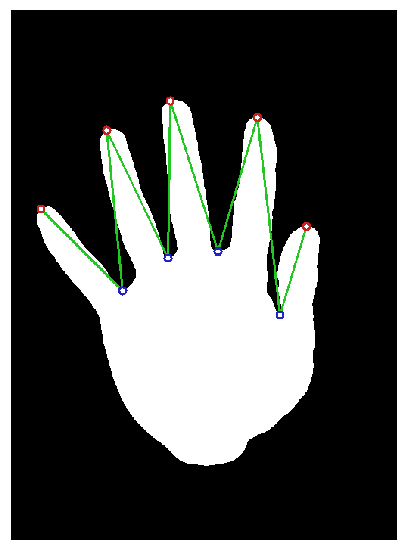

Image: 014


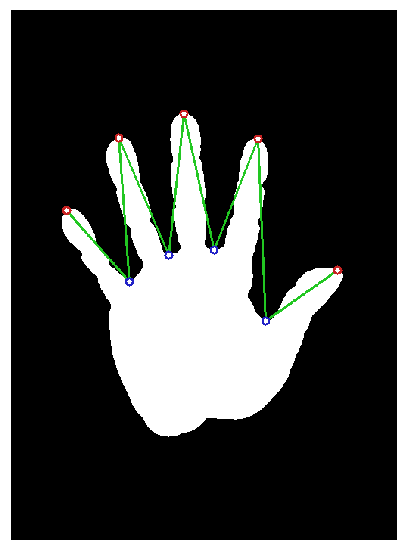

In [64]:
for i in ['002', '035', '093', '014']:
    filename = "training/{}.tif".format(i)
    print "Image: {}".format(i)

    img_gray = cv2.imread(filename, 0)

    img_hand = create_hand_mask(img_gray)
    img_hand, tform = position_hand_mask(img_hand)
    img_hand, img_palm, img_fingers = create_palm_and_fingers_masks(img_hand)

    func(img_hand, img_palm, img_fingers)

Подход модифицированного сканирования показывает отличные результаты – на всех изображениях из тренировчной выборки он отработал корректно. Данный алгоритм во многом лишен первых двух недостатков метода сканирования.

Главный **недостаток** данного алгоритма – большая сложность (как и в строках кода, так и в логике работы).

### 2.2.2.4. Скелетирование

Рассмотрим следующий подход к поиску ключевых точек. Данный метод основан на поиске скелетов у пальцев.

In [65]:
filename = "training/005.tif"

img_gray = cv2.imread(filename, 0)
img_color = cv2.imread(filename, 1)

img_gray_bak = img_gray.copy()
img_color_bak = img_color.copy()

In [66]:
img_hand = create_hand_mask(img_gray)
img_hand, tform = position_hand_mask(img_hand)
img_hand, img_palm, img_fingers = create_palm_and_fingers_masks(img_hand)

In [67]:
def skeleton_endpoints(skeleton, neighbours=1):
    skeleton = skeleton.copy()
    skeleton[skeleton > 0] = 1
    skeleton = skeleton.astype(np.uint8)

    kernel = np.array(
        [[1,  1, 1],
         [1, 10, 1],
         [1,  1, 1]], dtype=np.uint8)
    filtered = cv2.filter2D(skeleton, -1, kernel)

    result = np.zeros(skeleton.shape)
    result[np.where(filtered == 10 + neighbours)] = 1
    return result

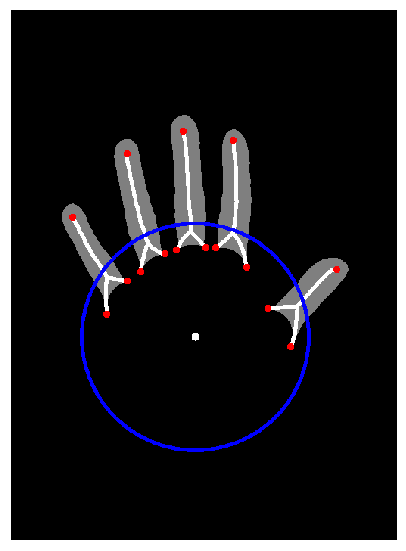

In [68]:
skeleton = skeletonize(img_fingers > 0)
skeleton_raw = skeleton.copy()
skeleton = scale_image_pixels(skeleton)
skeleton = cv2.dilate(skeleton, brush_5)
skeleton = scale_image_pixels(skeleton > 0)

img_tmp = img_fingers.copy()
img_tmp = (img_tmp > 0) * 127
img_tmp = img_tmp.astype(np.uint8)
img_tmp = np.maximum(skeleton, img_tmp)
img_color = gray2rgb(img_tmp)

img_tmp = skeleton_endpoints(skeleton_raw)
img_tmp = scale_image_pixels(img_tmp)
img_tmp = cv2.dilate(img_tmp, brush_5, iterations=2)

img_color[np.where(img_tmp > 0)] = (0, 0, 255)

img_props = regionprops(label(img_palm))[0]
radius = int(img_props.major_axis_length) // 2 + 30
row, col = map(int, img_props.centroid)
cv2.circle(img_color, (col, row), radius, (255, 0 , 0), 3)
cv2.circle(img_color, (col, row), 5, (255, 255, 255), -1)

plot_image(img_color)

В данном методе предлагается искать низины на основе скелетов пальцев, см. изображение выше. У пальца в основании есть две концевые точки скелета, тогда точкой впадины будет среднее между парами этих точек для соседних пальцев.

Кончики будут находиться любым другим методом, например, модифицированного сканирования.

In [69]:
def func_palm(img_fingers, img_palm):
    skeleton = skeletonize(img_fingers > 0)
    skeleton = skeleton_endpoints(skeleton)
    
    img_props = regionprops(label(img_palm))[0]
    row_center, col_center = img_props.centroid
    center = np.array((col_center, row_center), ndmin=2)
    
    radius = img_props.major_axis_length / 2 + 30
    
    p_valleys = np.where(skeleton > 0)
    p_valleys = zip(p_valleys[1], p_valleys[0])
    p_valleys = filter(lambda p: np.linalg.norm(np.array(p) - center) < radius, p_valleys)
    p_valleys = np.vstack(p_valleys)
    
    index = argsort_vertices(p_valleys, center)
    p_valleys = p_valleys[index]
    
    return p_valleys

In [70]:
def func(img_hand, img_palm, img_fingers):
    img_color = gray2rgb(img_fingers)
    
    img_props = regionprops(label(img_palm))[0]
    row_center, col_center = img_props.centroid
    center = np.array((col_center, row_center), dtype=np.int32)
    
    cv2.circle(img_color, (center[0], center[1]), 5, (255, 0, 255), -1)

    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 0, 255), (255, 255, 0)]
    p_valleys = func_palm(img_fingers, img_palm)

    for i, (col, row) in enumerate(p_valleys.astype(np.int32)):
        cv2.line(img_color, tuple(center), (col, row), colors[i // 2], 1)
        cv2.circle(img_color, (col, row), 5, colors[i // 2], -1)
    cv2.circle(img_color, tuple(center), 5, (255, 255, 255), -1)

    plot_image(img_color)

Image: 002


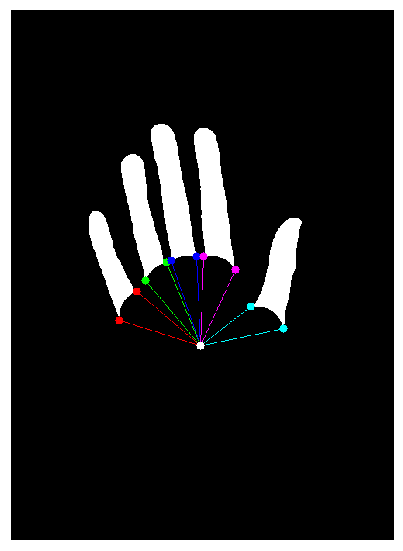

Image: 014


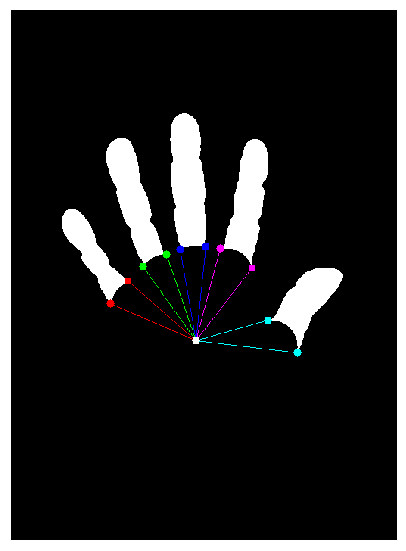

Image: 035


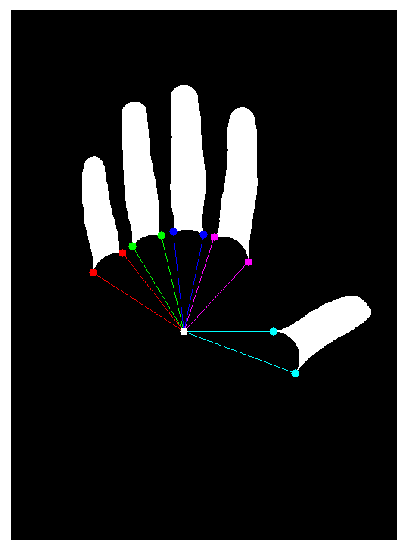

Image: 093


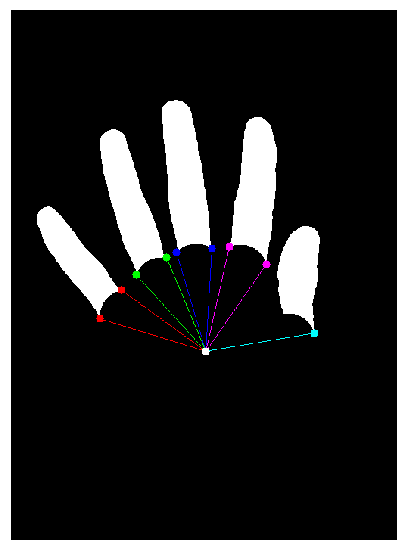

In [71]:
for i in ['002', '014', '035', '093']:
    filename = "training/{}.tif".format(i)
    print "Image: {}".format(i)

    img_gray = cv2.imread(filename, 0)

    img_hand = create_hand_mask(img_gray)
    img_hand, tform = position_hand_mask(img_hand)
    img_hand, img_palm, img_fingers = create_palm_and_fingers_masks(img_hand)
    
    func(img_hand, img_palm, img_fingers)

Данный метод показывает себя на большинстве изображений неплохо, однако у него есть один неприятный недостаток, который не позволяет нам его использовать. Этот недостаток заключается в том, что метод сильно ситуативен, зависит от качества локализованной области руки. Если одна из точек не будет существовать, как на одном из изображений выше, то это не получится исправить.

### 2.2.2.5. Поиск экстремумов на границе

Есть предположение, что кончики пальцев наиболее удалены от центра ладони, а впадины – ближе всего. Данный подход заключается в поиске локальных экстремумов для функции $$d(x, c) = \lVert x - c \rVert_2$$ где
* x – точка на границе;
* с – центр ладони.

Для выделения границы воспользуемся [детектором границ Кенни](https://docs.opencv.org/3.4.1/da/d22/tutorial_py_canny.html).

In [72]:
from scipy.signal import argrelmin, argrelmax

from skimage.feature import canny

In [73]:
filename = "training/135.tif"

img_gray = cv2.imread(filename, 0)

In [74]:
img_hand = create_hand_mask(img_gray)
img_hand, tform = position_hand_mask(img_hand)
img_hand, img_palm, img_fingers = create_palm_and_fingers_masks(img_hand)

Выделяем контур с помощью детектора Кенни.

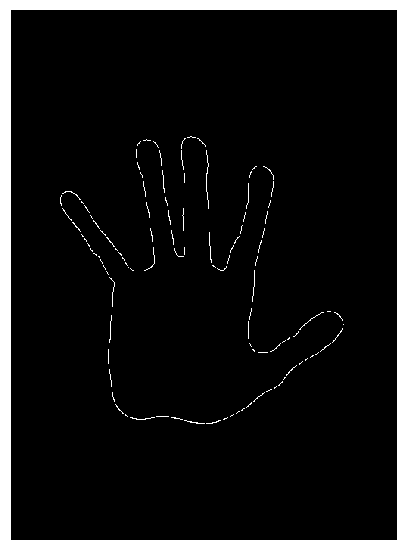

In [75]:
img_countour = canny(img_hand)
img_countour = scale_image_pixels(img_countour)
plot_image(img_countour)

Считаем расстояние до каждой точек контура из центра ладони, затем ищем локальные минимумы и максимумы получившейся функции. 

In [76]:
img_props = regionprops(label(img_palm))[0]
row_center, col_center = img_props.centroid
center = np.array((col_center, row_center), ndmin=2)

In [77]:
countour_p = np.where(img_countour > 0)
countour_p = np.array(zip(countour_p[1], countour_p[0]))
index = argsort_vertices(countour_p, center[0])
countour_p = countour_p[index]
countour_d = distance_matrix(center, countour_p)[0]

countour_sup = countour_p[argrelmax(countour_d, order=70)[0]]
countour_inf = countour_p[argrelmin(countour_d, order=30)[0]]

index = argsort_vertices(countour_sup, center[0])
countour_sup = countour_sup[index][:5]

index = argsort_vertices(countour_inf, center[0])
countour_inf = countour_inf[index]

radius = img_props.major_axis_length / 2 + 10
mask = map(lambda point: np.linalg.norm(center - point) < radius, countour_inf)
countour_inf = countour_inf[mask]

countour_inf = choose_unique_points(countour_inf, 40.0)
index = argsort_vertices(countour_inf, center[0])
countour_inf = countour_inf[index]    

In [78]:
def get_angles(vertices, center):
    vertices = np.array(vertices, dtype=np.float32, ndmin=2)
    center = np.array(center, dtype=np.float32, ndmin=2)

    assert 2 == vertices.shape[1] == center.shape[1]

    def cart2pol(vectors):
        rho = np.linalg.norm(vectors, axis=1)
        phi = np.arctan2(vectors[:, 1], vectors[:, 0])
        return rho, phi

    vertices -= center
    vertices *= np.array([[1, -1]])
    _, angles = cart2pol(vertices)
    return angles

In [79]:
angles_sup = get_angles(countour_sup, center)
angles_inf = get_angles(countour_inf, center)

In [80]:
index, i = [], 0
for a_i, a in enumerate(angles_inf):
    if i == 0 and a > angles_sup[i]:
        continue
    elif i < len(angles_sup) - 1 and a < angles_sup[i]:
        i += 1
        index.append(a_i)
countour_inf = countour_inf[index]

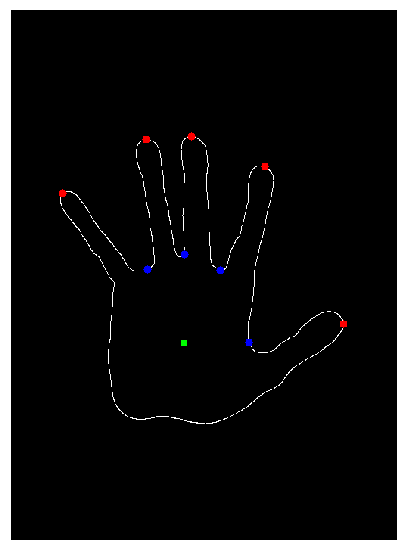

In [81]:
img_color = gray2rgb(img_countour)
cv2.circle(img_color, (int(center[0][0]), int(center[0][1])), 5, (0, 255, 0), -1)
for col, row in countour_sup:
    cv2.circle(img_color, (col, row), 5, (0, 0, 255), -1)
for col, row in countour_inf:
    cv2.circle(img_color, (col, row), 5, (255, 0, 0), -1)
plot_image(img_color)

In [82]:
def func_vertices(img_hand, img_palm):
    img_countour = canny(img_hand)
    img_countour = scale_image_pixels(img_countour)
    
    img_props = regionprops(label(img_palm))[0]
    row_center, col_center = img_props.centroid
    center = np.array((col_center, row_center), ndmin=2)
    
    countour_p = np.where(img_countour > 0)
    countour_p = np.array(zip(countour_p[1], countour_p[0]))
    index = argsort_vertices(countour_p, center[0])
    countour_p = countour_p[index]
    countour_d = distance_matrix(center, countour_p)[0]

    countour_sup = countour_p[argrelmax(countour_d, order=70)[0]]
    countour_inf = countour_p[argrelmin(countour_d, order=30)[0]]

    index = argsort_vertices(countour_sup, center[0])
    countour_sup = countour_sup[index][:5]
    
    index = argsort_vertices(countour_inf, center[0])
    countour_inf = countour_inf[index]

    radius = img_props.major_axis_length / 2 + 10
    mask = map(lambda point: np.linalg.norm(center - point) < radius, countour_inf)
    countour_inf = countour_inf[mask]

    countour_inf = choose_unique_points(countour_inf, 40.0)
    index = argsort_vertices(countour_inf, center[0])
    countour_inf = countour_inf[index]
    
    angles_sup = get_angles(countour_sup, center)
    angles_inf = get_angles(countour_inf, center)
    
    for a_i, a in enumerate(angles_inf):
        if a > np.pi - np.pi / 12:
            continue
        else:
            break
    
    countour_inf = countour_inf[a_i:a_i+4]
    
    return countour_sup, countour_inf

In [83]:
def func(img_hand, img_palm, img_fingers):
    p_tips, p_valleys = func_vertices(img_hand, img_palm)
    p_tips = p_tips.astype(np.int32)
    p_valleys = p_valleys.astype(np.int32)
    
    img_color = gray2rgb(img_hand)
    
    for p1, p2 in zip(p_tips[:-1], p_valleys):
        cv2.line(img_color, tuple(p1), tuple(p2), (34, 199, 34), 2)
    for p1, p2 in zip(p_tips[1:], p_valleys):
        cv2.line(img_color, tuple(p1), tuple(p2), (34, 199, 34), 2)
    
    for col, row in p_tips:
        cv2.circle(img_color, (col, row), 6, (34, 34, 199), -1)
        cv2.circle(img_color, (col, row), 3, (255, 255, 255), -1)
    
    for col, row in p_valleys:
        cv2.circle(img_color, (col, row), 6, (199, 34, 34), -1)
        cv2.circle(img_color, (col, row), 3, (255, 255, 255), -1)
    
    plot_image(img_color)

Image: 014


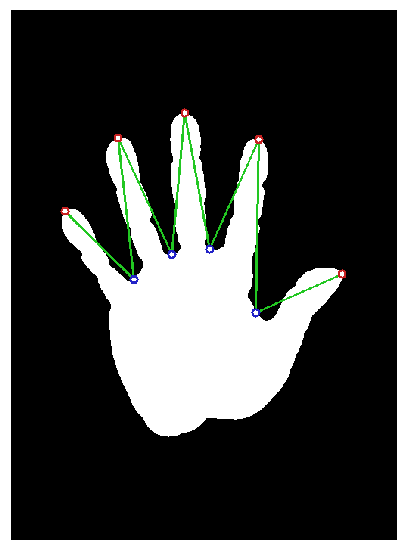

Image: 035


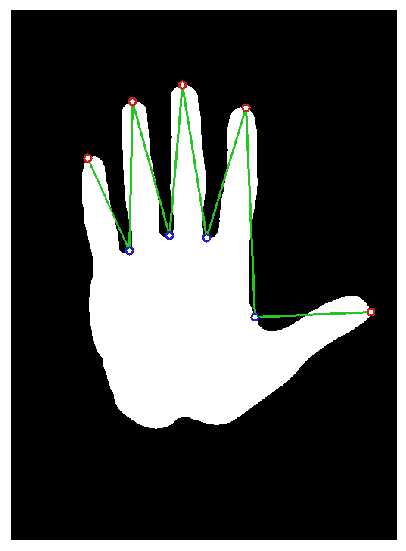

Image: 041


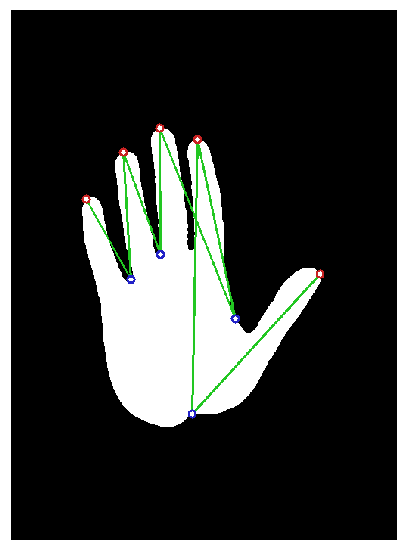

Image: 057


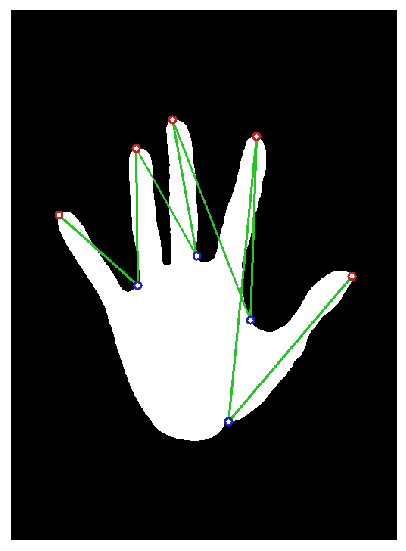

In [84]:
for i in ['014', '035', '041', '057']:
    filename = "training/{}.tif".format(i)
    print "Image: {}".format(i)

    img_gray = cv2.imread(filename, 0)

    img_hand = create_hand_mask(img_gray)
    img_hand, tform = position_hand_mask(img_hand)
    img_hand, img_palm, img_fingers = create_palm_and_fingers_masks(img_hand)
    
    func(img_hand, img_palm, img_fingers)

Данный метод показывает себя на большинстве изображений неплохо, особенно в поиске кончиков пальцев. Однако если область между пальцами не велика, то в поиске впадин возникают проблемы, с которыми трудно справиться. Эти проблемы свзяны с особенностями "грубой" сортировки точек границы.

В данном подходе точки границы сортируются относительно центра ладони (сортируются в порядке убывания полярного угла). Такая сортировка не гарантирует правильной сортировки всех точек контура, поэтому назовем такую сортировку "грубой".

Для поиска низин можно пользоваться любым подходящим методом из списка выше.

### 2.2.2.6. Поиск внутренних углов

Перейдем наконец-то к последнему подходу. Поиск внутренних углов помогает локализовать впадины между пальцами. Поиск внтуренних углов осуществляется следующим способом:
1. находится контур ладони и пальцев;
* контур приближается ломаной;
* на полученном контуре строится выпуклая оболочка;
* по внутренней оболочке находятся внутренние углы.

In [85]:
def func_valleys(img_hand, img_palm):
    _, contours, hierarchy = cv2.findContours(img_hand, 2, 1)
    contour = contours[0]

    convex_hull = cv2.convexHull(contour, returnPoints=False)
    defects = cv2.convexityDefects(contour, convex_hull)

    p_valleys = []

    for i in range(defects.shape[0]):
        _, _ , f, d_area = defects[i,0]
        if d_area > 10000:
            p_valleys.append(tuple(contour[f][0]))
    
    radius = int(img_props.major_axis_length) // 2 + 30
    p_valleys = filter(lambda p: np.linalg.norm(np.array(p) - center[0]) < radius, p_valleys)
    index = argsort_vertices(p_valleys, center[0])
    p_valleys = [p_valleys[i] for i in index]

    # Если мезинец сильно отогнут, то он тоже создает большую область
    if len(p_valleys) > 4:
        p_valleys = p_valleys[1:]
        
    return p_valleys

In [86]:
def func(img_hand, img_palm, img_fingers):
    img_color = gray2rgb(img_hand)

    p_valleys = func_valleys(img_hand, img_palm)
    for col, row in p_valleys:
        cv2.circle(img_color, (col, row), 5, (255, 0, 0), -1)

    plot_image(img_color)

Image: 014


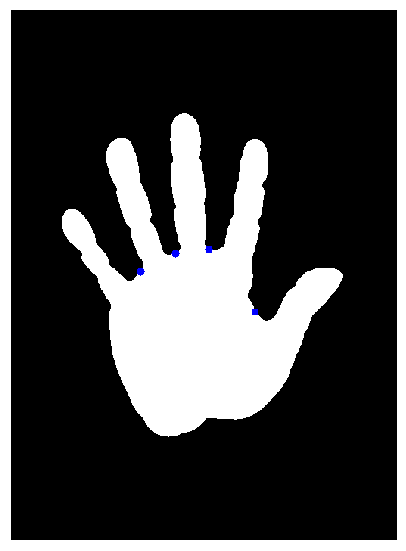

Image: 035


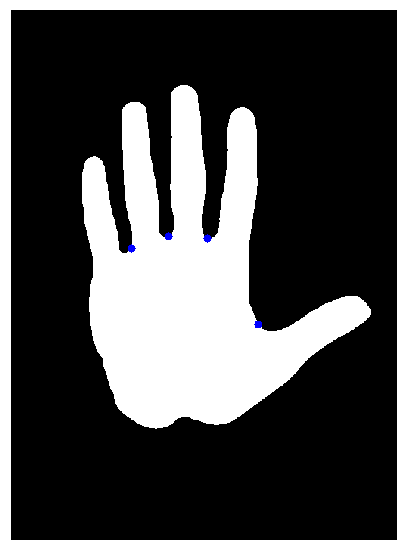

Image: 041


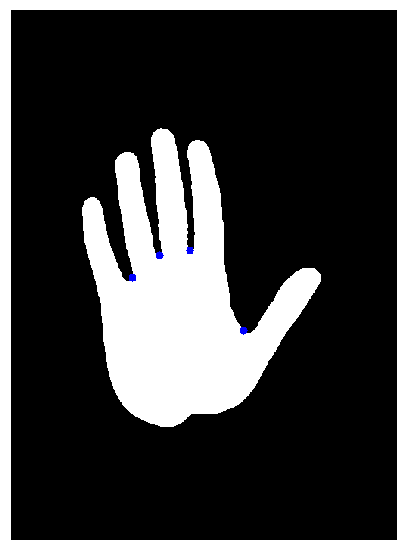

Image: 057


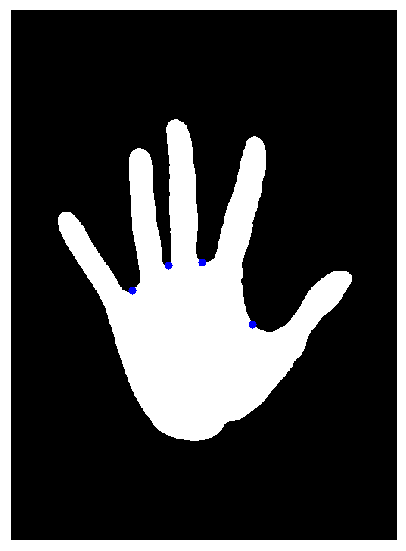

In [87]:
for i in ['014', '035', '041', '057']:
    filename = "training/{}.tif".format(i)
    print "Image: {}".format(i)

    img_gray = cv2.imread(filename, 0)

    img_hand = create_hand_mask(img_gray)
    img_hand, tform = position_hand_mask(img_hand)
    img_hand, img_palm, img_fingers = create_palm_and_fingers_masks(img_hand)
    
    func(img_hand, img_palm, img_fingers)

Данный метод отлично справляется со свое задачей. Особых недостатков нет.

### 2.2.2.7. Итоговый алгоритм

В качестве итогового алгоритма поиска ключевых точек используется следующая комбинация:
* низины между пальцами ищутся поиском внутренних углов;
* кончики пальцев – поиском экстремумов на границе.

In [88]:
from processing import extract_tips_and_valleys, draw_vertices_on_image
from processing.utils.transform import transform_vertices

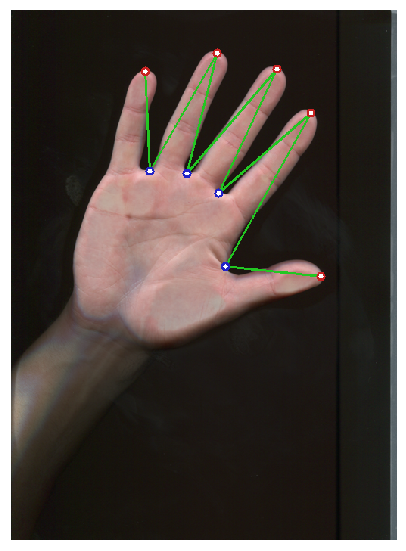

In [89]:
filename = "training/006.tif"

img_gray = cv2.imread(filename, 0)
img_color = cv2.imread(filename, 1)

img_hand = create_hand_mask(img_gray)
img_hand, tform = position_hand_mask(img_hand)
img_hand, img_palm, img_fingers = create_palm_and_fingers_masks(img_hand)

vertices = extract_tips_and_valleys(img_hand, img_palm, img_fingers)
vertices = transform_vertices(vertices, tform)

img_color = draw_vertices_on_image(img_color, vertices)
plot_image(img_color)

## 2.3. Кластеризация

In [90]:
filename = "training/138.tif"

img_gray = cv2.imread(filename, 0)
img_color = cv2.imread(filename, 1)

img_hand = create_hand_mask(img_gray)
img_hand, tform = position_hand_mask(img_hand)
img_hand, img_palm, img_fingers = create_palm_and_fingers_masks(img_hand)

vertices = extract_tips_and_valleys(img_hand, img_palm, img_fingers)
vertices = transform_vertices(vertices, tform)

### 2.3.1. Описание признаков

In [91]:
def vertices2chain(vertices):
    vertices = np.array(vertices, dtype=np.float32, ndmin=2)
    assert vertices.shape[1] == 2
    chain = vertices[1:,] - vertices[:-1,]
    return chain

Начнем с того признака, который предлагается реализовать в задании, – длины 8 звеньев ломаной "линии пальцев".

In [92]:
def chain_parts_length(vertices):
    chain = vertices2chain(vertices)
    chain_length = np.linalg.norm(chain, axis=1)
    return chain_length

In [93]:
chain_parts_length(vertices)

array([140.0357 , 202.6746 , 175.6929 , 199.0226 , 194.99998, 177.76668,
       217.0069 , 113.70135], dtype=float32)

Величина (ориентированных ?) углов между звеньями ломаной.

In [94]:
def measure_angle_between(v1, v2, oriented=False):
    def norm(vector):
        return vector / np.linalg.norm(vector)
    v1, v2 = norm(v1), norm(v2)
    vcos = np.clip(np.dot(v1, v2), -1.0, 1.0)
    angle = np.arccos(vcos)
        
    if oriented:
        vsin = np.clip(np.cross(v1, v2), -1.0, 1.0)
        if vsin < 0:
            angle = -angle
    
    return angle

def chain_parts_angles(vertices, oriented=False):
    chain = vertices2chain(vertices)   
    angles = [measure_angle_between(chain[i], chain[i+1], oriented)
              for i in range(len(chain) - 1)]
    angles = np.array(angles)
    return angles

In [95]:
chain_parts_angles(vertices)

array([2.5050328, 2.8728135, 2.7592487, 2.9079568, 2.7517815, 2.8338275,
       2.0898619], dtype=float32)

In [96]:
chain_parts_angles(vertices, oriented=True)

array([-2.5050328,  2.8728135, -2.7592487,  2.9079568, -2.7517815,
        2.8338275, -2.0898619], dtype=float32)

Ширина и длина пальцев.

In [97]:
def fingers_features(img_fingers):
    assert check_image_consistency(img_fingers)
    
    """
    Двойное транспонирование для того, чтобы пальцы шли в следующем порядке:
        мезинец        1
        безымянный     2
        средний        3
        указательный   4
        большой        5
    """
    img_labels = label(img_fingers.T).T
    img_props = regionprops(img_labels)
    
    features = []
    for prop in img_props:
        prop_f = (prop.major_axis_length, prop.minor_axis_length)
        features.append(prop_f)
    return features

In [98]:
fingers_features(img_fingers)

[(158.64089565154435, 42.49047399505529),
 (202.31191412234216, 45.63176861915544),
 (215.03258277444874, 44.5628332123578),
 (196.07089394710604, 49.368522664059306),
 (107.07053035844527, 54.618020656334544)]

Радиус "вписанной" окружности в ладонь.

In [99]:
def incircle(img):
    assert check_image_consistency(img)
    
    distance = cv2.distanceTransform(img, cv2.DIST_L2, 5)
    row_center, col_center = np.unravel_index(
        np.argmax(distance, axis=None), distance.shape)
    radius = distance[row_center, col_center]
    
    return (col_center, row_center), radius

In [100]:
_, radius = incircle(img_palm)
radius

106.18408

Различные статистики яркостей пикселей. Данный признак должен помочь различать цвет кожи.

In [101]:
def stats_mask_pixels_intesity(img_gray, img_mask, func):
    assert check_image_consistency(img_mask)
    return func(img_gray[np.where(img_mask > 0)])

def mean_hand_pixels_intensity(img_gray, img_hand):
    return stats_mask_pixels_intesity(img_gray, img_hand, np.mean)

def median_hand_pixels_intensity(img_gray, img_hand):
    return stats_mask_pixels_intesity(img_gray, img_hand, np.median)

def percentile_hand_pixels_intensity(img_gray, img_hand, percentile):
    return stats_mask_pixels_intesity(img_gray, img_hand, lambda x: np.percentile(x, percentile))

In [102]:
img_mask = tf.warp(img_hand, tform.inverse)
img_mask = scale_image_pixels(img_mask)

print mean_hand_pixels_intensity(img_gray, img_mask)
print median_hand_pixels_intensity(img_gray, img_mask)
print percentile_hand_pixels_intensity(img_gray, img_mask, 95)
print percentile_hand_pixels_intensity(img_gray, img_mask, 5)

134.09284733556126
142.0
166.0
79.0


Признаки связанные с текстурой.

**ROI:** Будем полагать, что region of interest (ROI) представляет собой область размером 128 на 128 пикселей, с центром в центре ладони.

Воспользуемся двумерным вейвлет-преобразованием. После применения к исходному изображению получаем разложения по частотам: LL, LH, HL, HH. Каждый элемент разложения (кроме LL) можно фильтровать: оставлять частоты не попадающищие в диапазон [q_0.05, q_0.95] (q_a – квантиль порядка a).

Разобьем полученные разложения (кроме LL) на несколько пулов. В каждом пуле будем подсчитывать среднюю энергию.

In [103]:
from pywt import dwt2

from skimage.feature import greycomatrix, greycoprops

In [104]:
def wavelet_transform(img, wavelet='haar', steps=2, pool=4):
    tempf = np.zeros_like(img)
    energies = []

    def filter_frequencies(img, pcnt_low, pcnt_high):
        assert pcnt_low < pcnt_high

        img = img.copy()
        low, high = np.percentile(img, [pcnt_low, pcnt_high])
        img[np.where(np.logical_and(low < img, img < high))] = 0
        return img

    LL = img / 255.0
    for i in range(steps):
        LL, (LH, HL, HH) = dwt2(LL, wavelet=wavelet)

#         LH = filter_frequencies(LH, 5, 95)
#         HL = filter_frequencies(HL, 5, 95)
#         HH = filter_frequencies(HH, 5, 95)

        row_step, col_step = LL.shape[0] // pool, LL.shape[1] // pool
        for row in range(0, LL.shape[0], row_step):
            for col in range(0, LL.shape[1], col_step):
                energies.extend(map(lambda x: np.power(x, 2.0).sum(), [
                    LH[row:row + row_step, col:col + col_step],
                    HL[row:row + row_step, col:col + col_step],
                    HH[row:row + row_step, col:col + col_step]
                ]))

        LH, HL, HH = map(scale_image_pixels, map(np.abs, [LH, HL, HH]))

        tempf[0:LL.shape[0], 0:LL.shape[1]] = LL
        tempf[0:LH.shape[0], LL.shape[1]:LL.shape[1] + LH.shape[1]] = LH
        tempf[LL.shape[0]:LL.shape[0] + HL.shape[0], 0:HL.shape[1]] = HL
        tempf[LL.shape[0]:LL.shape[0] + HH.shape[0], LL.shape[1]:LL.shape[1] + HH.shape[1]] = HH

    tempf[0:LL.shape[0], 0:LL.shape[1]] = scale_image_pixels(LL)
    tempf = scale_image_pixels(tempf)

    return tempf, energies

К полученному "изображению" после применения вейвлет-преобразования применим подход [co-occurrence matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix) для извлечения дополнительных признаков.

In [105]:
def texture_features(img_gray, img_palm, tform):
    img_props = regionprops(label(img_palm))[0]
    row_center, col_center = map(int, img_props.centroid)
    row_center -= 10

    img_patch = tf.warp(img_gray, tform)
    img_patch = scale_image_pixels(img_patch)
    img_patch = img_patch[row_center - 64:row_center + 64, col_center - 64:col_center + 64]
    plot_image(img_patch, 0.5)

    img_patch, energies = wavelet_transform(img_patch)
    plot_image(img_patch, 0.5)

    features = dict()

    angles = [0, 90]
    glcm = greycomatrix(img_patch, [5], angles, 256, symmetric=True, normed=True)
    for prop in ['contrast', 'energy', 'dissimilarity', 'correlation']:
        for alpha, val in zip(angles, greycoprops(glcm, prop)[0]):
            features['texture_{}_{:02d}'.format(prop, alpha)] = val
    
    features.update({"wavelet_{}".format(i): e for i, e in enumerate(energies)})
    return features, img_patch

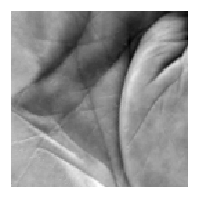

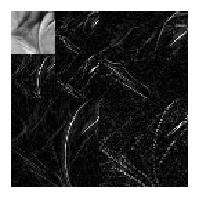

{'texture_contrast_00': 1301.2900787601627,
 'texture_contrast_90': 1160.4437403993863,
 'texture_correlation_00': 0.5173591416896034,
 'texture_correlation_90': 0.5785155361080412,
 'texture_dissimilarity_00': 21.229484247967488,
 'texture_dissimilarity_90': 19.634216589861744,
 'texture_energy_00': 0.07233173310941217,
 'texture_energy_90': 0.07322100782211573}

In [106]:
f, _ = texture_features(img_gray, img_palm, tform)
{k: v for k, v in f.iteritems() if k.startswith('texture')}

Итоговые признаки, включенные модели:
* длины звеньев ломаной "линии пальцев";
* ширина и длина пальцев;
* радиус "вписанной" окружности;
* медиана яркости пикселей;
* признаки извлеченные с помощью подхода co-occurence matrix.

In [107]:
from processing.features import extract_features

### 2.3.2. Кластеризация

В качестве алгоритма кластеризации будем использовать метод К-средних.

In [108]:
df = pd.read_csv("data/ml_set_features.csv")
df["img"] = df["img"].apply(lambda s: os.path.splitext(os.path.basename(s))[0])
features = filter(lambda x: x != "img", df.columns)
df = df[["img"] + features]
df.head()

,img,chain_0_len,chain_1_len,chain_2_len,chain_3_len,chain_4_len,chain_5_len,chain_6_len,chain_7_len,fingure_0_len,...,median_skin_color,palm_circle_radius,texture_contrast_00,texture_contrast_90,texture_correlation_00,texture_correlation_90,texture_dissimilarity_00,texture_dissimilarity_90,texture_energy_00,texture_energy_90
0,001,119.402695,174.103439,149.723083,182.002747,182.887939,169.186295,242.216858,142.302490,142.768226,...,169.0,87.875977,1912.694106,1759.532002,0.414512,0.469336,29.996570,28.710189,0.058770,0.058404
1,002,118.983200,173.933884,148.189041,178.549698,181.041428,168.297363,236.349335,133.775940,141.876126,...,163.0,85.399628,1283.529726,1181.845110,0.606213,0.649379,22.569995,20.907834,0.057494,0.057684
2,003,133.689957,179.354401,164.003036,182.134552,182.010986,160.252930,235.732895,127.769318,147.800053,...,172.0,98.322296,1846.839494,1664.088902,0.420286,0.484815,28.732025,27.277330,0.075598,0.076531
3,004,129.834503,179.354385,160.461823,182.332108,178.101105,160.822891,227.369736,122.674377,146.782700,...,173.0,99.860474,2564.410124,2301.800115,0.275255,0.351973,35.684134,33.364375,0.072617,0.074148
4,005,133.660019,181.339462,164.538742,184.458649,181.804825,163.024536,230.360611,131.848404,146.451198,...,155.0,98.860474,1665.288364,1535.418779,0.502943,0.539305,27.005716,26.089542,0.080140,0.081211


In [109]:
df.columns

Index([u'img', u'chain_0_len', u'chain_1_len', u'chain_2_len', u'chain_3_len',
       u'chain_4_len', u'chain_5_len', u'chain_6_len', u'chain_7_len',
       u'fingure_0_len', u'fingure_0_width', u'fingure_1_len',
       u'fingure_1_width', u'fingure_2_len', u'fingure_2_width',
       u'fingure_3_len', u'fingure_3_width', u'fingure_4_len',
       u'fingure_4_width', u'median_skin_color', u'palm_circle_radius',
       u'texture_contrast_00', u'texture_contrast_90',
       u'texture_correlation_00', u'texture_correlation_90',
       u'texture_dissimilarity_00', u'texture_dissimilarity_90',
       u'texture_energy_00', u'texture_energy_90'],
      dtype='object')

Отнормируем признаки.

In [110]:
from sklearn.preprocessing import StandardScaler

In [111]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features].values)
df.head()

,img,chain_0_len,chain_1_len,chain_2_len,chain_3_len,chain_4_len,chain_5_len,chain_6_len,chain_7_len,fingure_0_len,...,median_skin_color,palm_circle_radius,texture_contrast_00,texture_contrast_90,texture_correlation_00,texture_correlation_90,texture_dissimilarity_00,texture_dissimilarity_90,texture_energy_00,texture_energy_90
0,001,-1.252828,-0.608559,-1.267841,-0.394258,-0.417000,-0.027068,-0.363467,0.398938,-0.644455,...,1.776776,-1.318500,0.300053,0.128095,-0.598610,-0.350525,0.486021,0.399517,-1.203832,-1.239030
1,002,-1.281368,-0.619403,-1.366212,-0.633870,-0.545311,-0.093101,-0.606199,-0.192399,-0.713240,...,1.198788,-1.597994,-1.142244,-1.297370,1.044906,1.291458,-0.963826,-1.159771,-1.301530,-1.294112
2,003,-0.280824,-0.272721,-0.352129,-0.385111,-0.477938,-0.690672,-0.631700,-0.608973,-0.256480,...,2.065769,-0.139471,0.149088,-0.107414,-0.549103,-0.209355,0.239151,0.113162,0.084503,0.148636
3,004,-0.543122,-0.272722,-0.579212,-0.371403,-0.749629,-0.648333,-0.977674,-0.962320,-0.334922,...,2.162101,0.034136,1.794049,1.466163,-1.792497,-1.420873,1.596371,1.329648,-0.143755,-0.033792
4,005,-0.282861,-0.145762,-0.317777,-0.223838,-0.492264,-0.484787,-0.853945,-0.326079,-0.360483,...,0.428139,-0.078730,-0.267100,-0.424913,0.159539,0.287593,-0.097866,-0.124215,0.432195,0.506909


Попробуем выбрать количество кластеров.

In [112]:
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from scipy.spatial.distance import pdist, cdist

In [113]:
scores, dists, clusters = [], [], range(1, 27)

kf = KFold(n_splits=5)

for n_clusters in clusters:
    scores_, dists_ = [], []
    for index, _ in kf.split(df[features].values):
        cl = KMeans(n_clusters=n_clusters, max_iter=1000)
        cl.fit(df.loc[index, features].values)
        scores_.append(cl.inertia_)
        dist = pdist(cl.cluster_centers_).mean() if n_clusters > 1 else 0
        dists_.append(dist)
    scores.append(np.mean(scores_))
    dists.append(np.mean(dists_))

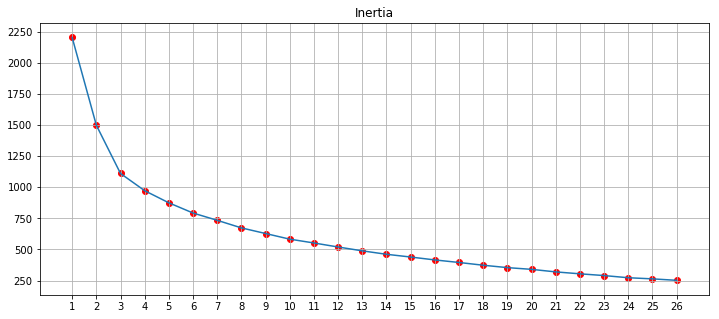

In [114]:
plt.figure(figsize=(12, 5))
plt.plot(clusters, scores)
plt.title("Inertia")
plt.scatter(clusters, scores, c='red')
plt.xticks(clusters)
plt.grid()
plt.show()

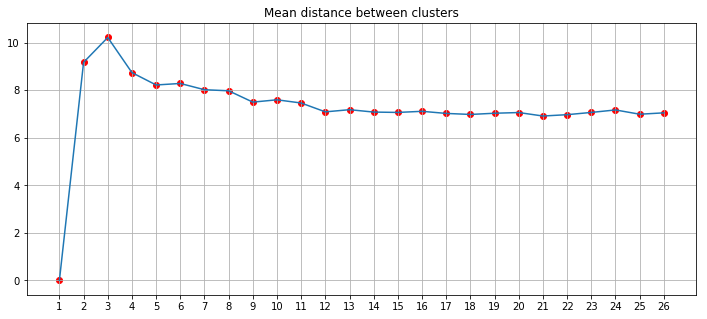

In [115]:
plt.figure(figsize=(12, 5))
plt.plot(clusters, dists)
plt.title("Mean distance between clusters")
plt.scatter(clusters, dists, c='red')
plt.xticks(clusters)
plt.grid()
plt.show()

По графикам "лучшее" число кластеров 3, однако это никак не кореллирует с действительностью (в датасете куда больше людей). Поэтому выберем число кластеров равным 20.

In [116]:
n_clusters = 20

cl = KMeans(n_clusters=n_clusters, max_iter=2000, tol=1e-6, random_state=8001)
cl.fit(df[features].values)
Y_pred = cl.predict(df[features].values)
df_users = pd.DataFrame(zip(df["img"], Y_pred), columns=["img", "label"])
df_users = df_users.groupby("label")

for y, group in df_users:
    print "person_{:02d}".format(y+1), sorted(group["img"].unique())

person_01 ['046', '076', '081', '082', '097', '099']
person_02 ['051', '052', '053', '054', '055', '068', '077', '078', '079']
person_03 ['071', '150', '151', '152']
person_04 ['112', '113', '114']
person_05 ['092', '109', '120', '122', '124', '126', '127']
person_06 ['016', '018', '019', '020', '056', '057']
person_07 ['009', '039', '047', '088', '091', '145']
person_08 ['041', '049', '050', '060']
person_09 ['035', '036', '138', '141']
person_10 ['022', '023', '093', '096']
person_11 ['026', '027', '028', '029']
person_12 ['142', '144', '146']
person_13 ['012', '013', '014', '015']
person_14 ['105', '106', '107', '135', '157']
person_15 ['003', '005', '008', '010', '011', '017', '021', '037', '065', '086']
person_16 ['001', '002']
person_17 ['004', '006', '007', '090', '155']
person_18 ['024', '031', '111']
person_19 ['095', '118', '123']
person_20 ['034', '063', '064', '066', '067', '128', '129']


Попробуем визуализировать кластеризацию с помощью [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

In [117]:
from sklearn.manifold import TSNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 99 samples in 0.000s...
[t-SNE] Computed neighbors for 99 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 99 / 99
[t-SNE] Mean sigma: 2.642173
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.226208
[t-SNE] Error after 1000 iterations: 0.286402


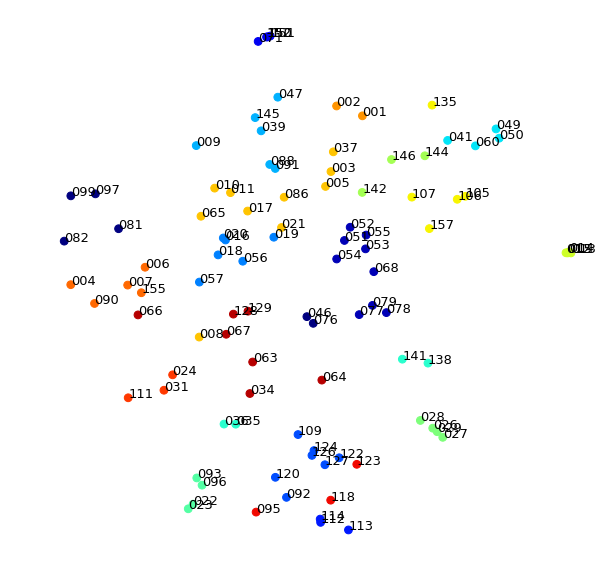

In [118]:
tsne = TSNE(n_components=2, verbose=1, n_iter=1000)
X_pred = tsne.fit_transform(df[features].values)

cm = plt.get_cmap('jet')

plt.figure(figsize=(10, 10))
plt.scatter(X_pred[:,0], X_pred[:,1], c=map(lambda c: cm(1.0 * c / n_clusters), Y_pred), s=60)
for x, y, l in zip(X_pred[:,0], X_pred[:,1], df["img"]):
    plt.annotate(l, xy=(x, y), textcoords='data', size=13)
plt.axis('off')
plt.show()

Для каждого изображения выберем 3 наиболее "похожих" на него.

In [119]:
distances = cdist(df[features], df[features])
index = np.argsort(distances, axis=1)[:,1:4]
for i, img_name in enumerate(df["img"]):
    print "'{}'".format(img_name), '\t', df["img"].iloc[index[i]].tolist()

'001' 	['016', '002', '037']
'002' 	['001', '017', '021']
'003' 	['005', '006', '065']
'004' 	['007', '090', '003']
'005' 	['086', '003', '006']
'006' 	['007', '155', '003']
'007' 	['155', '006', '090']
'008' 	['067', '011', '086']
'009' 	['011', '010', '088']
'010' 	['011', '086', '065']
'011' 	['010', '086', '021']
'012' 	['015', '013', '014']
'013' 	['014', '015', '012']
'014' 	['015', '013', '012']
'015' 	['014', '013', '012']
'016' 	['020', '018', '017']
'017' 	['020', '016', '019']
'018' 	['016', '020', '056']
'019' 	['021', '056', '018']
'020' 	['016', '018', '017']
'021' 	['019', '086', '051']
'022' 	['023', '096', '093']
'023' 	['022', '096', '120']
'024' 	['031', '155', '079']
'026' 	['029', '028', '027']
'027' 	['029', '026', '028']
'028' 	['029', '026', '027']
'029' 	['026', '027', '028']
'031' 	['024', '034', '111']
'034' 	['063', '109', '124']
'035' 	['036', '109', '034']
'036' 	['035', '063', '141']
'037' 	['005', '003', '017']
'039' 	['037', '145', '052']
'041' 	['060',

### 2.3.3. Transfer learning

Попробуем подход transfer learning для задачи кластеризации. Подход заключается в следующем:
* возьмем уже готовую предобученную сверточную нейронную сеть, например, [VGG16](https://arxiv.org/abs/1409.1556);
* построим скрытое представление (embedding) для каждого из изображений, путь взятия выхода некоторого слоя сети;
* будем сравнивать полученные скрытые представления между собой с помощью косинусного расстояния.

В качестве алгоритма кластеризации будем использовать агломеративную ирерархическую кластеризацию. В качестве метрики будем использовать [косинусное расстояние](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf).

In [120]:
from sklearn.cluster import AgglomerativeClustering

In [121]:
from keras.preprocessing import image
from keras import backend as K


def preprocess_input(x, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    assert dim_ordering in {'tf', 'th'}

    x = x.astype(np.float32)
    if dim_ordering == 'th':
        x[:, 0, :, :] -= 103.939
        x[:, 1, :, :] -= 116.779
        x[:, 2, :, :] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
    else:
        x[:, :, :, 0] -= 103.939
        x[:, :, :, 1] -= 116.779
        x[:, :, :, 2] -= 123.68
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
    return x

Using TensorFlow backend.
/home/vladimir/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [122]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.optimizers import SGD

In [123]:
base_model = VGG16()

In [124]:
import operator

class ImageDataBase:    
    def __init__(self, path, model, index, batch_size=10):
        self.model = Model(input=model.input, outputs=model.layers[index].output)
        sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        self.model.compile(optimizer=sgd, loss='categorical_crossentropy')
        
        out_layer = model.get_layer(index=index)
        self.out_dim = reduce(operator.mul, out_layer.output_shape[1:])
        
        self.batch_size = batch_size
        
        self.files_input, self.features = self._extract_features(path)
            
    def _extract_features(self, path):
        files_input = sorted(map(lambda x: path + x, os.listdir(path)))
        num_files = len(files_input)
        
        features = np.zeros(shape=(num_files, self.out_dim), dtype=float)
        n_images = 0
        
        for batch_i in range(0, num_files, self.batch_size):
            images = map(lambda x: image.load_img(x, target_size=(224, 224)),
                         files_input[batch_i: batch_i + self.batch_size])
            images = map(lambda x: np.array(x, dtype=np.uint8), images)
            images = preprocess_input(np.array(images))
            images = self.model.predict(images)
            images = images.reshape(-1, self.out_dim)
            
            features[batch_i: batch_i + self.batch_size] = images
            
            n_images += len(images)
            print "\r{} of {} images processed...".format(n_images, num_files),
            
        return files_input, features
    
    def get_features(self):
        return self.files_input, self.features

#### Модель на основе выделения области 128 х 128 пикселей на ладони.

In [125]:
image_base = ImageDataBase(path='./data/img_roi_128/', model=base_model, index=19)

/home/vladimir/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("fl..., inputs=Tensor("in...)`


99 of 99 images processed...


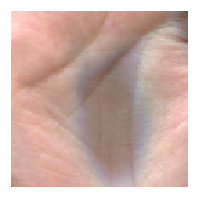

In [126]:
Y_names, X_features = image_base.get_features()

img_color = cv2.imread(Y_names[0], 1)
plot_image(img_color, 0.5)

Y_names = map(lambda s: os.path.splitext(os.path.basename(s))[0], Y_names)

In [127]:
n_clusters = 20

cl = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='complete')
Y_pred = cl.fit_predict(X_features)

In [128]:
df_users = pd.DataFrame(zip(Y_names, Y_pred), columns=["img", "label"])
df_users = df_users.groupby("label")

for y, group in df_users:
    print "person_{:02d}".format(y), sorted(group["img"].unique())

person_00 ['009', '010', '011', '092', '093', '096']
person_01 ['039', '064']
person_02 ['012', '013', '014', '015', '065', '068', '081', '082', '138', '155']
person_03 ['037', '041', '046', '056', '060', '077', '078']
person_04 ['050', '090']
person_05 ['071', '150', '151', '152']
person_06 ['026', '027', '028', '029', '051', '052', '053', '054', '055', '057', '076', '079', '095', '109', '111', '122', '123', '124', '126', '127', '135', '142']
person_07 ['003', '004', '005', '006', '007', '008']
person_08 ['097', '099', '105', '106', '107']
person_09 ['034', '066']
person_10 ['001', '002']
person_11 ['049', '144', '146', '157']
person_12 ['035', '067', '086', '088', '091']
person_13 ['016', '017', '018', '020', '031', '063']
person_14 ['145']
person_15 ['036']
person_16 ['112', '113', '114']
person_17 ['022', '023', '141']
person_18 ['019', '021', '024', '118', '120', '128', '129']
person_19 ['047']


Достоинства данной кластеризации:
* не учитывается форма ладони.

Недостатки данной кластеризации:
* маленькая рецептивная область;
* наличие большого кластера и многих маленьких;
* изображения '012', '013', '014', '015' не выделены в один кластер.

#### Модель на основе области соответвующей ладони.

In [129]:
image_base = ImageDataBase(path='./data/img_palm/', model=base_model, index=19)

/home/vladimir/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("fl..., inputs=Tensor("in...)`


99 of 99 images processed...


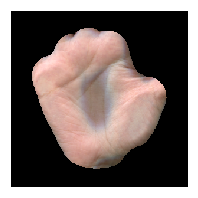

In [130]:
Y_names, X_features = image_base.get_features()

img_color = cv2.imread(Y_names[0], 1)
plot_image(img_color, 0.5)

Y_names = map(lambda s: os.path.splitext(os.path.basename(s))[0], Y_names)

In [131]:
n_clusters = 20

cl = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='complete')
Y_pred = cl.fit_predict(X_features)

In [132]:
df_users = pd.DataFrame(zip(Y_names, Y_pred), columns=["img", "label"])
df_users = df_users.groupby("label")

for y, group in df_users:
    print "person_{:02d}".format(y), sorted(group["img"].unique())

person_00 ['022', '023', '076', '079', '092', '093', '096']
person_01 ['010', '016', '017', '020', '065', '068', '138', '141', '144', '155']
person_02 ['095', '112', '113', '114', '118', '120']
person_03 ['034', '066', '082']
person_04 ['071', '150', '151', '152']
person_05 ['018', '019', '021', '031', '051', '052', '054', '055', '109', '111', '122', '123', '124', '126', '127', '128', '129']
person_06 ['012', '013', '014', '015', '026', '027', '028', '029', '077', '078', '081']
person_07 ['046', '063', '135']
person_08 ['003', '004', '005', '006', '007', '037', '056', '057', '146']
person_09 ['039', '064', '145']
person_10 ['001', '002']
person_11 ['008', '024', '041', '053', '060', '067', '086', '142']
person_12 ['105', '106', '107']
person_13 ['097', '099']
person_14 ['049', '157']
person_15 ['035', '036']
person_16 ['047', '088', '091']
person_17 ['090']
person_18 ['009', '011']
person_19 ['050']


Достоинства данной кластеризации:
* не учитывается форма ладони.

Недостатки данной кластеризации:
* наличие большого кластера;
* изображения '012', '013', '014', '015' не выделены в один кластер.

#### Модель на основе области соотвевующей руке.

In [133]:
image_base = ImageDataBase(path='./data/img_hand/', model=base_model, index=19)

/home/vladimir/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("fl..., inputs=Tensor("in...)`


99 of 99 images processed...


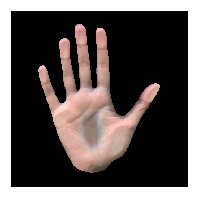

In [134]:
Y_names, X_features = image_base.get_features()

img_color = cv2.imread(Y_names[0], 1)
plot_image(img_color, 0.5)

Y_names = map(lambda s: os.path.splitext(os.path.basename(s))[0], Y_names)

In [135]:
n_clusters = 20

cl = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='complete')
Y_pred = cl.fit_predict(X_features)

In [136]:
df_users = pd.DataFrame(zip(Y_names, Y_pred), columns=["img", "label"])
df_users = df_users.groupby("label")

for y, group in df_users:
    print "person_{:02d}".format(y), sorted(group["img"].unique())

person_00 ['035', '036', '088', '090', '091']
person_01 ['010', '016', '017', '020', '064', '065', '138', '145', '155']
person_02 ['008', '047', '067', '086', '106', '107']
person_03 ['018', '019', '021', '022', '023', '024', '026', '028', '029', '076', '077', '078', '079', '124', '126']
person_04 ['003', '004', '005', '006', '007', '037', '056', '057', '060', '066', '128', '129']
person_05 ['049', '050', '144', '146', '157']
person_06 ['053', '095', '105']
person_07 ['051', '052', '054', '055', '122', '123', '142']
person_08 ['039', '082']
person_09 ['141']
person_10 ['031', '034', '093']
person_11 ['046', '063', '081', '097', '099']
person_12 ['027']
person_13 ['071', '150', '151', '152']
person_14 ['092', '109', '112', '113', '114', '118', '127']
person_15 ['012', '013', '014', '015']
person_16 ['135']
person_17 ['111', '120']
person_18 ['001', '002', '009', '011', '041', '068']
person_19 ['096']


Достоинства данной кластеризации:
* изображения '012', '013', '014', '015' выделены в один кластер.

Недостатки данной кластеризации:
* наличие большого кластера;
* учитывается форма ладони.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 99 samples in 0.000s...
[t-SNE] Computed neighbors for 99 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 99 / 99
[t-SNE] Mean sigma: 0.440125
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.005177
[t-SNE] Error after 1000 iterations: 0.306387


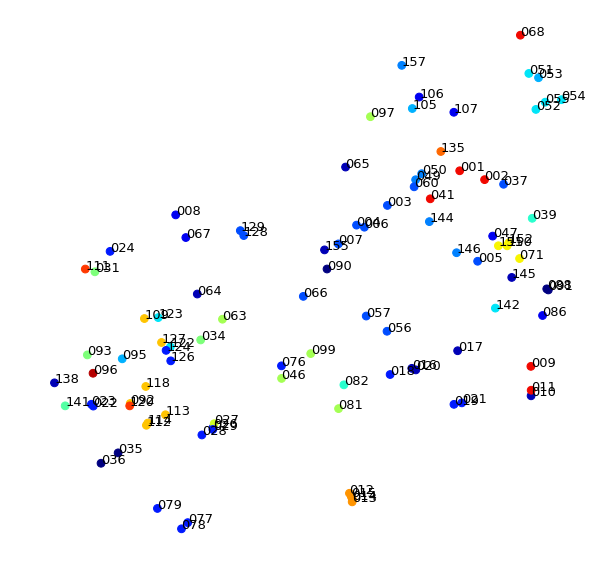

In [137]:
tsne = TSNE(n_components=2, verbose=1, metric='cosine', n_iter=1000)
X_pred = tsne.fit_transform(df[features].values)

cm = plt.get_cmap('jet')

plt.figure(figsize=(10, 10))
plt.scatter(X_pred[:,0], X_pred[:,1], c=map(lambda c: cm(1.0 * c / n_clusters), Y_pred), s=60)
for x, y, l in zip(X_pred[:,0], X_pred[:,1], df["img"]):
    plt.annotate(l, xy=(x, y), textcoords='data', size=13)
plt.axis('off')
plt.show()

#### Модель на основе всего изображения.

In [138]:
image_base = ImageDataBase(path='./training/', model=base_model, index=19)

/home/vladimir/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("fl..., inputs=Tensor("in...)`


99 of 99 images processed...


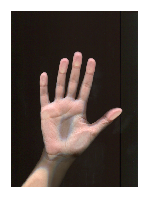

In [139]:
Y_names, X_features = image_base.get_features()

img_color = cv2.imread(Y_names[0], 1)
plot_image(img_color, 0.5)

Y_names = map(lambda s: os.path.splitext(os.path.basename(s))[0], Y_names)

In [140]:
n_clusters = 20

cl = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='complete')
Y_pred = cl.fit_predict(X_features)

In [141]:
df_users = pd.DataFrame(zip(Y_names, Y_pred), columns=["img", "label"])
df_users = df_users.groupby("label")

for y, group in df_users:
    print "person_{:02d}".format(y), sorted(group["img"].unique())

person_00 ['001', '002', '003', '023', '029', '034', '092', '093', '112', '113', '114', '118', '123']
person_01 ['039', '064', '145']
person_02 ['016', '018', '019', '021', '031', '041', '047', '067', '086', '129', '150']
person_03 ['027', '078', '088', '099', '106']
person_04 ['020', '026', '028', '065', '066']
person_05 ['004', '071', '107']
person_06 ['008', '009', '017', '052', '054', '057', '097']
person_07 ['010', '138']
person_08 ['076', '079', '128']
person_09 ['006', '011', '055', '141']
person_10 ['005', '007', '056', '060', '068', '127']
person_11 ['111']
person_12 ['096', '151']
person_13 ['022', '024', '037', '051', '081', '109', '122', '124', '126', '142', '144', '146', '155']
person_14 ['049', '063', '091', '105', '135', '157']
person_15 ['120']
person_16 ['012', '013', '014', '015']
person_17 ['050', '082', '090', '095', '152']
person_18 ['046', '053', '077']
person_19 ['035', '036']


Достоинства данной кластеризации:
* изображения '012', '013', '014', '015' выделены в один кластер.

Недостатки данной кластеризации:
* наличие двух больших кластеров;
* учитывается форма ладони;
* сильное сжатие изображения на входе в нейросеть.

**ИТОГ:** К сожалению, подход с transfer learning не сработал должным образом. Кажется, что кластеризация, полученная с помощью метода K-средних и рукотворных признаков симпатичнее.

# Выводы

В данной лабораторной работе нам пришлось решить 3 задачи:
* отделение фона от изображения ладоней;
* выделение ключевых точек;
* кластеризация изображений.

Светлая рука достаточно хорошо выражена на темном фоне, однако существует проблемы с полутонами, поэтому бинаризация изображения с выбором порога не всегда идеально. Возможно эта проблема могла бытьь решена с использованием методов динамического выбора порога.

Затем была произведена нормализация маски руки: центрирование и вращение руки так, чтобы средний палец смотрел вверх. Нормализация сильно облегчает создание алгоритма для локализации ключевых точек.

Были рассмотрены и опробованы множество различных алгоритмов для поиска ключевых точек. Многие из них достаточно ситуативные, многие применимы только в узких случаях. Не существует универсального подхода поиска ключевых точек, обязательно приходится учитывать специфику объекта (его форму и прочие факторы).

В данном конкретном случае мы воспрользовались подходом **поиска локальных максимумов на границе** для поиска кончиков пальцев и **методом поиска внутренних углов** для поиска низин между пальцами.

Для решения кластеризации были опробованы два подхода:
1. кластеризация на основе формирования собственных признаков;
2. использование подхода transfer learning.

В данной конкретной задаче лучше себя показала кластеризация методом K-средних на основе собственных признаков.